In [1]:
import os 
import re
import glob
import pywt
import joblib

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
PATH = '../data/synthetic/spectra/simulated_data/'
GENERATED_FILES_OUTPUT= '../data/synthetic/generated_files/'
MODELS_OUTPUT = '../data/models/'
PARAMETERS_OUTPUT = '../data/synthetic/params/'


# create all directories if they don't exist
# for directory in [GENERATED_FILES_OUTPUT, MODELS_OUTPUT, PARAMETERS_OUTPUT]:
#     if not os.path.exists(directory):
#         os.makedirs(directory)

files = sorted(glob.glob(PATH + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

# write_data = open(PARAMETERS_OUTPUT + 'model_parameters_data_all.txt', 'w')

# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#         # read in the data from each file
#         data = f.readlines()
#         # write the data to the output file in the same order as the files
#         for i in range(len(data)):
#             write_data.write(data[i])

# write_data.close()  

In [3]:
# get the params data
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
# df_param.to_csv(PARAMETERS_OUTPUT + 'model_parameters_data.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(PARAMETERS_OUTPUT + 'model_parameters_data_all.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [5]:
df_data.shape

(1160000000, 2)

In [6]:
df_param = pd.read_csv(PARAMETERS_OUTPUT + 'model_parameters_data.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  4.872648e+17  cm-2
2   tex  =  1.216546e+02     K
3  fwhm  =  5.252371e+00  km/s
4  vlsr  =  7.224510e+00  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A       fwhm          ntot      size  tcmb         tex       vlsr
g                                                                
0   5.252371  4.872648e+17  0.587752  2.73  121.654639   7.224510
1   8.140540  2.624419e+17  0.229623  2.73  242.849318   1.162407
2   9.448813  4.311923e+16  1.009372  2.73   44.772760 -35.479438
3   4.483937  1.031042e+17  0.998138  2.73  327.804816  33.196577
4   2.184235  1.521796e+17  0.250813  2.73  209.534300  40.915396
5   7.005622  1.697776e+17  0.642485  2.73  389.558322  15.791416
6  10.008192  8.811332e+17  0.179650  2.73  353.226798  46.752103
7   2.101555  1.624752e+16  0.125042  2.73  289.873535  34.760704
8  10.220350  4.187514e+16  1.019223  2.73  180.203878   2.342653
9   5.584003  8.824483e+17  0.262292  2.73   49.924559  22.416165

In [10]:
# drop the tcmb column
df_param.drop('tcmb', axis=1, inplace=True)


In [11]:

df_param.columns

Index(['fwhm', 'ntot', 'size', 'tex', 'vlsr'], dtype='object', name='A')

### Plot the distribution of the data

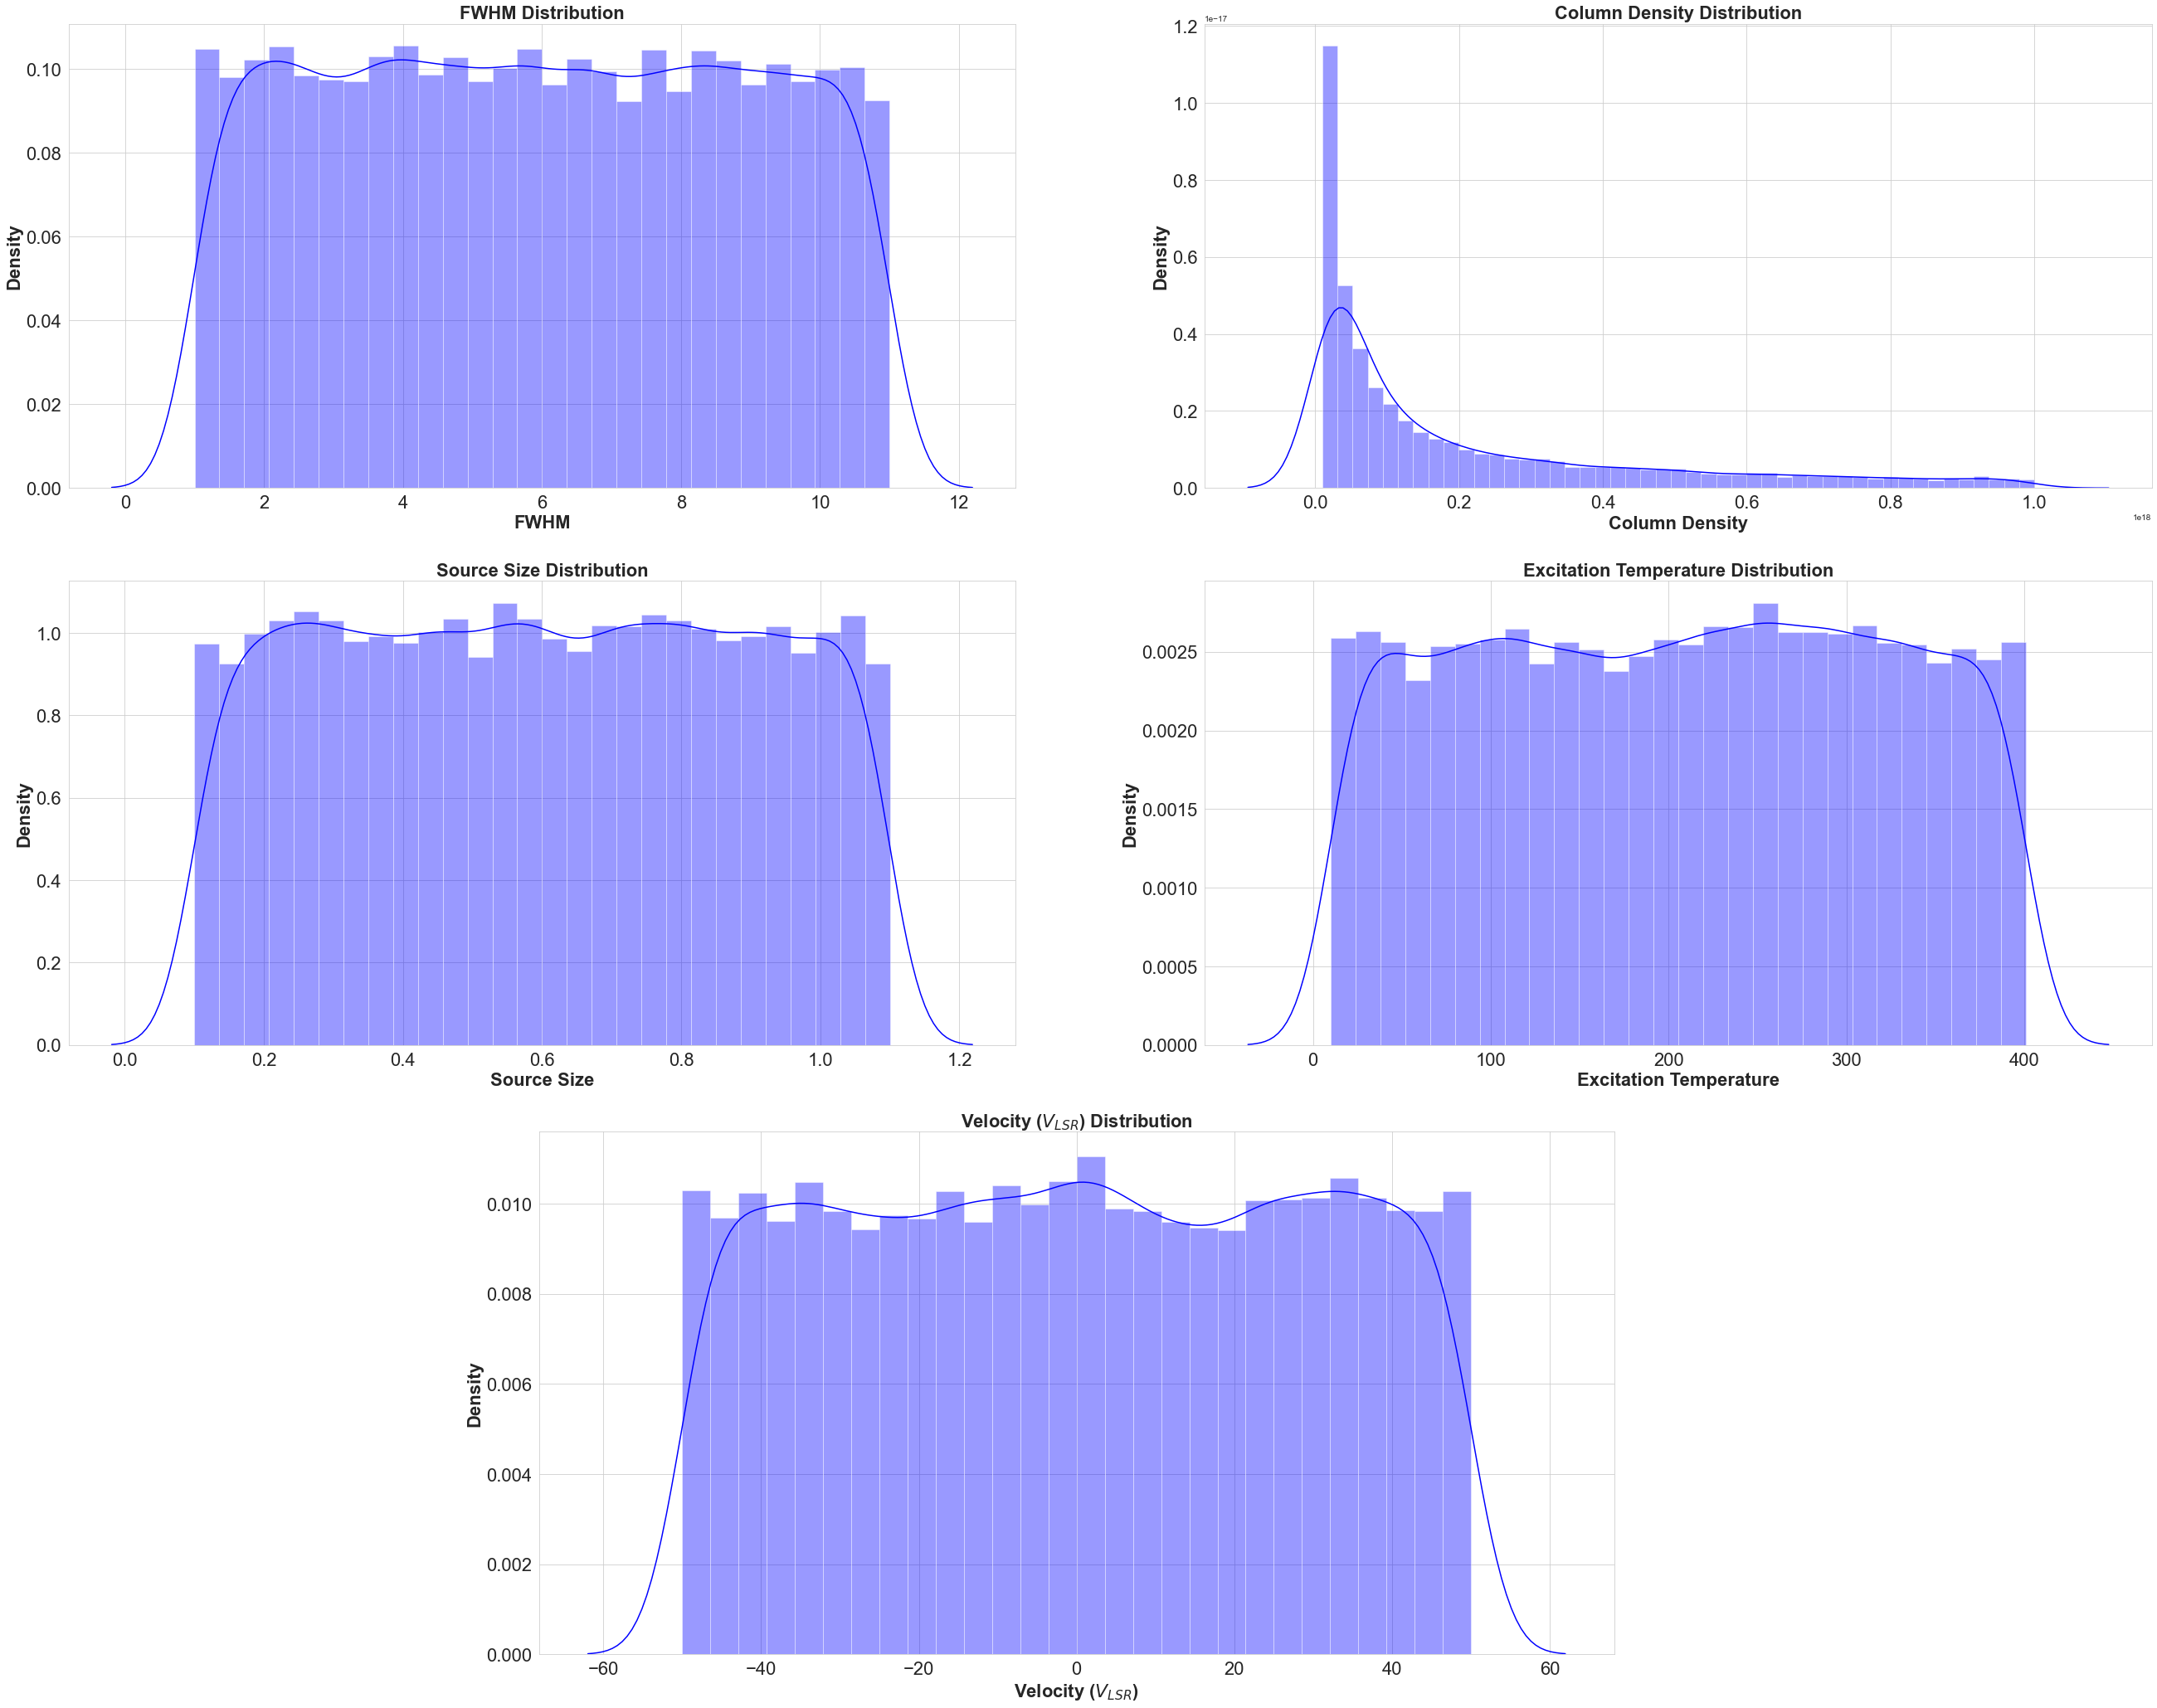

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
sns.set_style('white', {'axes.grid': False})
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.distplot(x=df_param['fwhm'], kde=True, ax=axes[0,0], color='blue') # fwhm
g2 = sns.distplot(x=df_param['ntot'], kde=True, ax=axes[0,1], color='blue') # column density
g3 = sns.distplot(x=df_param['size'], kde=True, ax=axes[1,0], color='blue') # size
g4 = sns.distplot(x=df_param['tex'], kde=True, ax=axes[1,1], color='blue') # tex
g5 = sns.distplot(x=df_param['vlsr'], kde=True, ax=axes[2,0], color='blue') # vlsr

g1.set(title='FWHM Distribution', xlabel='FWHM')
g2.set(title='Column Density Distribution', xlabel='Column Density')
g3.set(title='Source Size Distribution', xlabel='Source Size')
g4.set(title='Excitation Temperature Distribution', xlabel='Excitation Temperature')
g5.set(title='Velocity ($V_{LSR}$) Distribution', xlabel='Velocity ($V_{LSR}$)')

# bold the title of the plot
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=22, weight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=22, weight='bold')
    ax.set_title(ax.get_title(), fontsize=22, weight='bold')
    ax.tick_params(labelsize=22, length=5, width=2)

plt.savefig(GENERATED_FILES_OUTPUT + "param_distribution.pdf", dpi=15000)
plt.show()

In [13]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(1160000000, 2)

In [14]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

In [15]:
# filter out the data for the frequency of interest i.e., equal to or greater than 238.60 GHz to equal to or less than 239.18 GHz
df_data = df_data[(df_data['Frequency'] >= 238.91) & (df_data['Frequency'] <= 239.18)] 
df_data.shape



(540000000, 2)

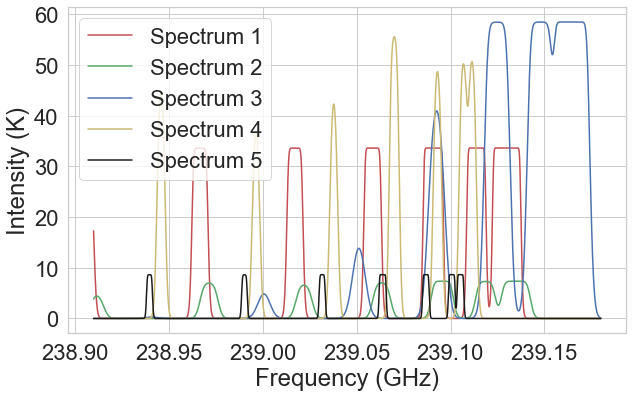

In [16]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

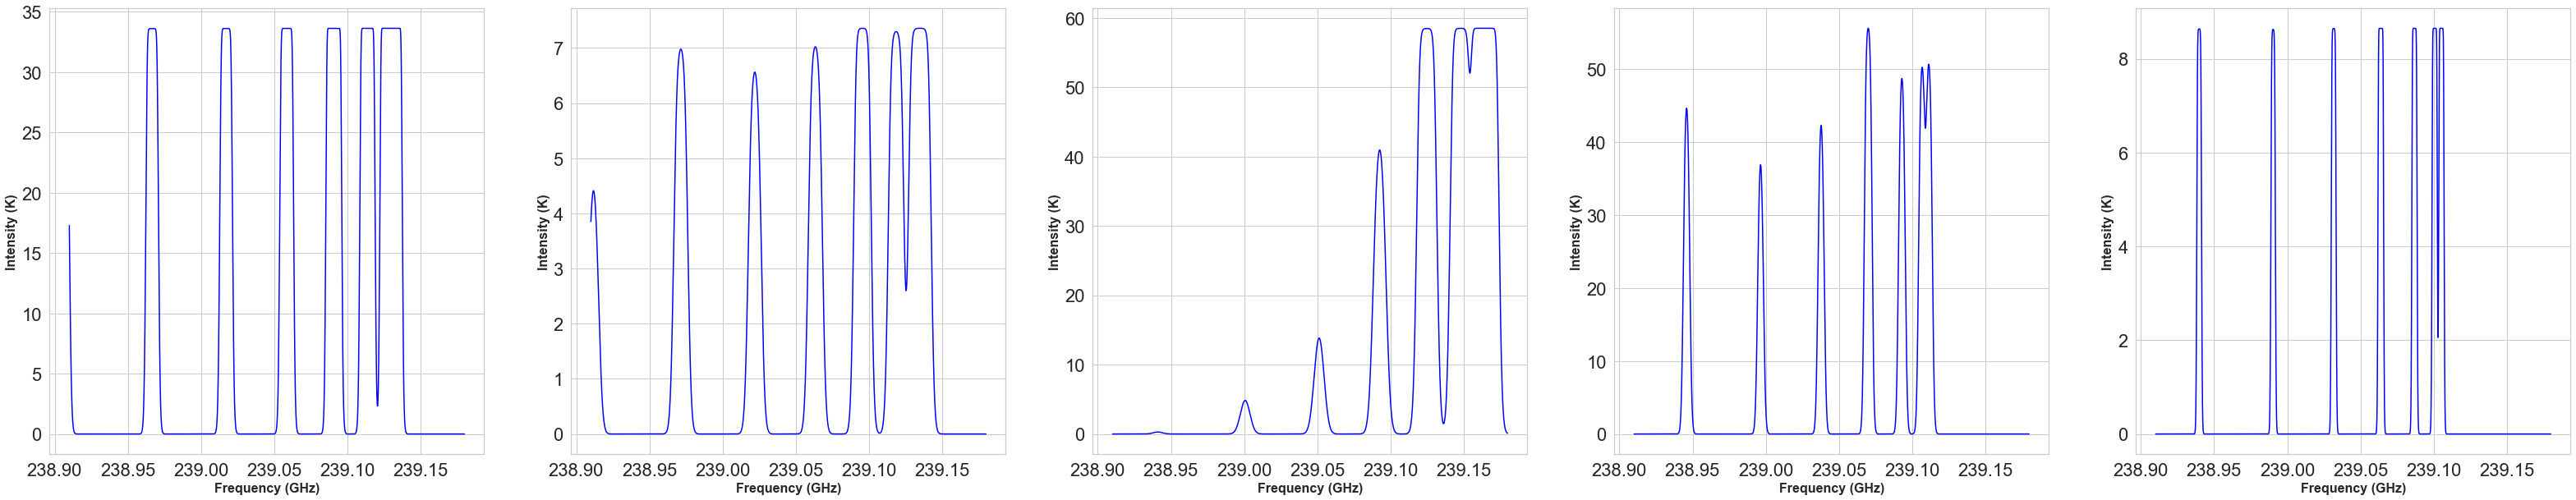

In [17]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(55, 10))
axes = axes.flatten()
sns.set_style("white", {'axes.grid': False})
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1],  color='blue')
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 16, 'fontweight': 'bold'})
    # ax.set_title("Spectra {}".format(i), fontdict={'fontsize': 14, 'fontweight': 'bold'})
    # plt.grid(True)
# plt.show()   
plt.savefig(GENERATED_FILES_OUTPUT +  'spectrum_plots.pdf', dpi=15000)

### Get the  distribution of the Intensity


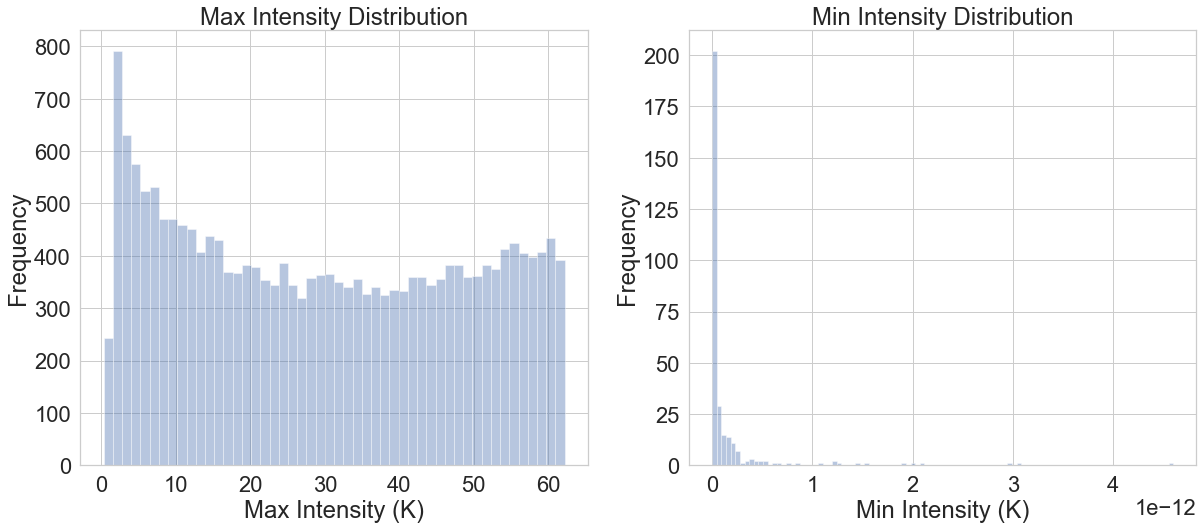

In [18]:
max = []
min = []
for i in range(len(files)):
    # get the max intensity for each spectrum
    max.append(np.max(signal[i]))
    # append the minimum value of the signal if the maximum value is not 0
    if np.min(signal[i]) != 0:
        min.append(np.min(signal[i]))

# plot the max and min of the signal as distributions of the signal
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
# plot the distribution of the max values for all spectra in one plot
plt.subplot(1, 2, 1)
sns.distplot(max, kde=False, bins=50)
plt.xlabel("Max Intensity (K)")
plt.ylabel("Frequency")
plt.title("Max Intensity Distribution")
# plot the distribution of the min values for all spectra in one plot
plt.subplot(1, 2, 2)
sns.distplot(min, kde=False, bins=100)
plt.xlabel("Min Intensity (K)")
plt.ylabel("Frequency")
plt.title("Min Intensity Distribution")
plt.show()


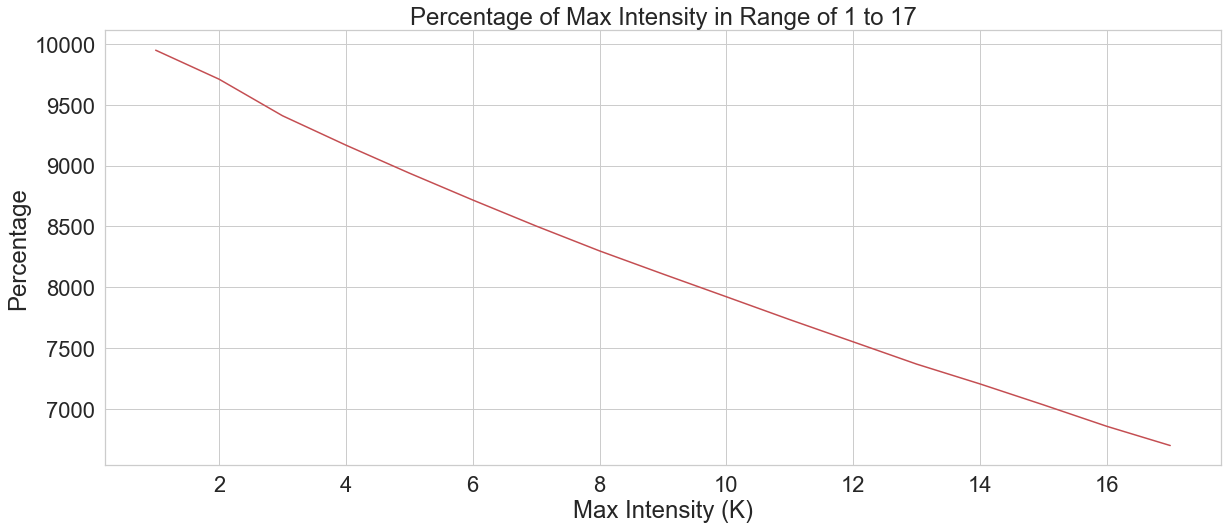

In [19]:
# get percentage of values in the range of 1 to 17 in the max distribution
max_range = np.arange(1, 18)
max_count = []
for i in max_range:
    max_count.append(np.sum(max > i))
max_count = np.array(max_count)
max_count = max_count / len(max)
max_count = max_count * 100



# plot the percentage of values in the range of 1 to 17 in the max distribution
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.plot(max_range, max_count * 100, color='r')
plt.xlabel("Max Intensity (K)")
plt.ylabel("Percentage")
plt.title("Percentage of Max Intensity in Range of 1 to 17")
plt.show()

i really do not understand this graph, im not sure how to interpret it :-D

In [20]:
# print(pywt.wavelist(kind='discrete'))

### Feature Extraction - Wavelet Decomposition

In [105]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 422))
approx_coeffs = np.zeros((len(signal), 422))
level = 6
wname = 'db1'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # level 7 detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [106]:
feature_vector.shape

(20000, 27000)

In [107]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
31000       238.91000  17.281427
31001       238.91001  17.167934
31002       238.91002  17.054380
31003       238.91003  16.940777
31004       238.91004  16.827133
...               ...        ...
1159999995  239.17995   1.677398
1159999996  239.17996   1.677398
1159999997  239.17997   1.677398
1159999998  239.17998   1.677399
1159999999  239.17999   1.677399

[540000000 rows x 2 columns]

In [108]:
detail_coeffs.shape
detail_coeffs

array([[ 1.40957457e+01,  1.05507852e+01,  5.94724599e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.55242064e-01, -3.76936205e-01, -8.81468642e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00093943e+00,  4.83474204e-01,  2.12929056e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.71619278e-05, -1.71619662e-05, -1.60893785e-05]])

## Wavelet Decomposition Plots

In [109]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [110]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [111]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [112]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [113]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [114]:
# len(signal)

approx_coeffs.shape

(20000, 422)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [115]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

In [116]:
# get the frequency axis to match the data points from the DWT
x_new_length = 422
x_new_freq = np.linspace(freq_sig.min(), freq_sig.max(), x_new_length)


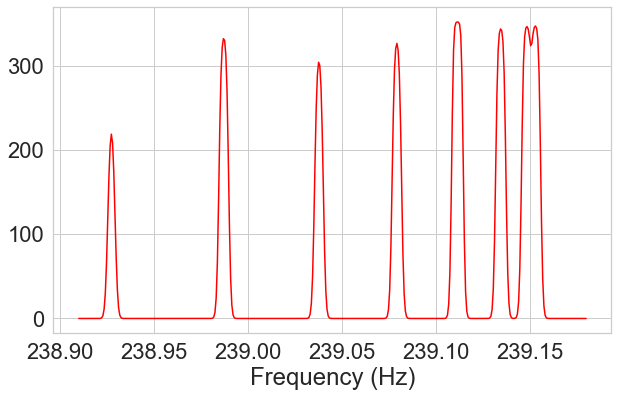

In [117]:
plt.figure(figsize=(10,6))
# plt.subplot(3,1,1)
# plt.plot(signal[18260])
# plt.savefig('signal_18260.png', dpi=400)
# plt.legend()
# plt.subplot(3,1,2)
plt.plot(x_new_freq, approx_coeffs[18260], color='red')
plt.xlabel('Frequency (Hz)')
plt.savefig('approx_coeffs_18260.png', dpi=400)

# plt.legend()
# plt.subplot(3,1,3)
# plt.plot(detail_coeffs[18260])
# plt.legend()
# save the subplots in a pdf file


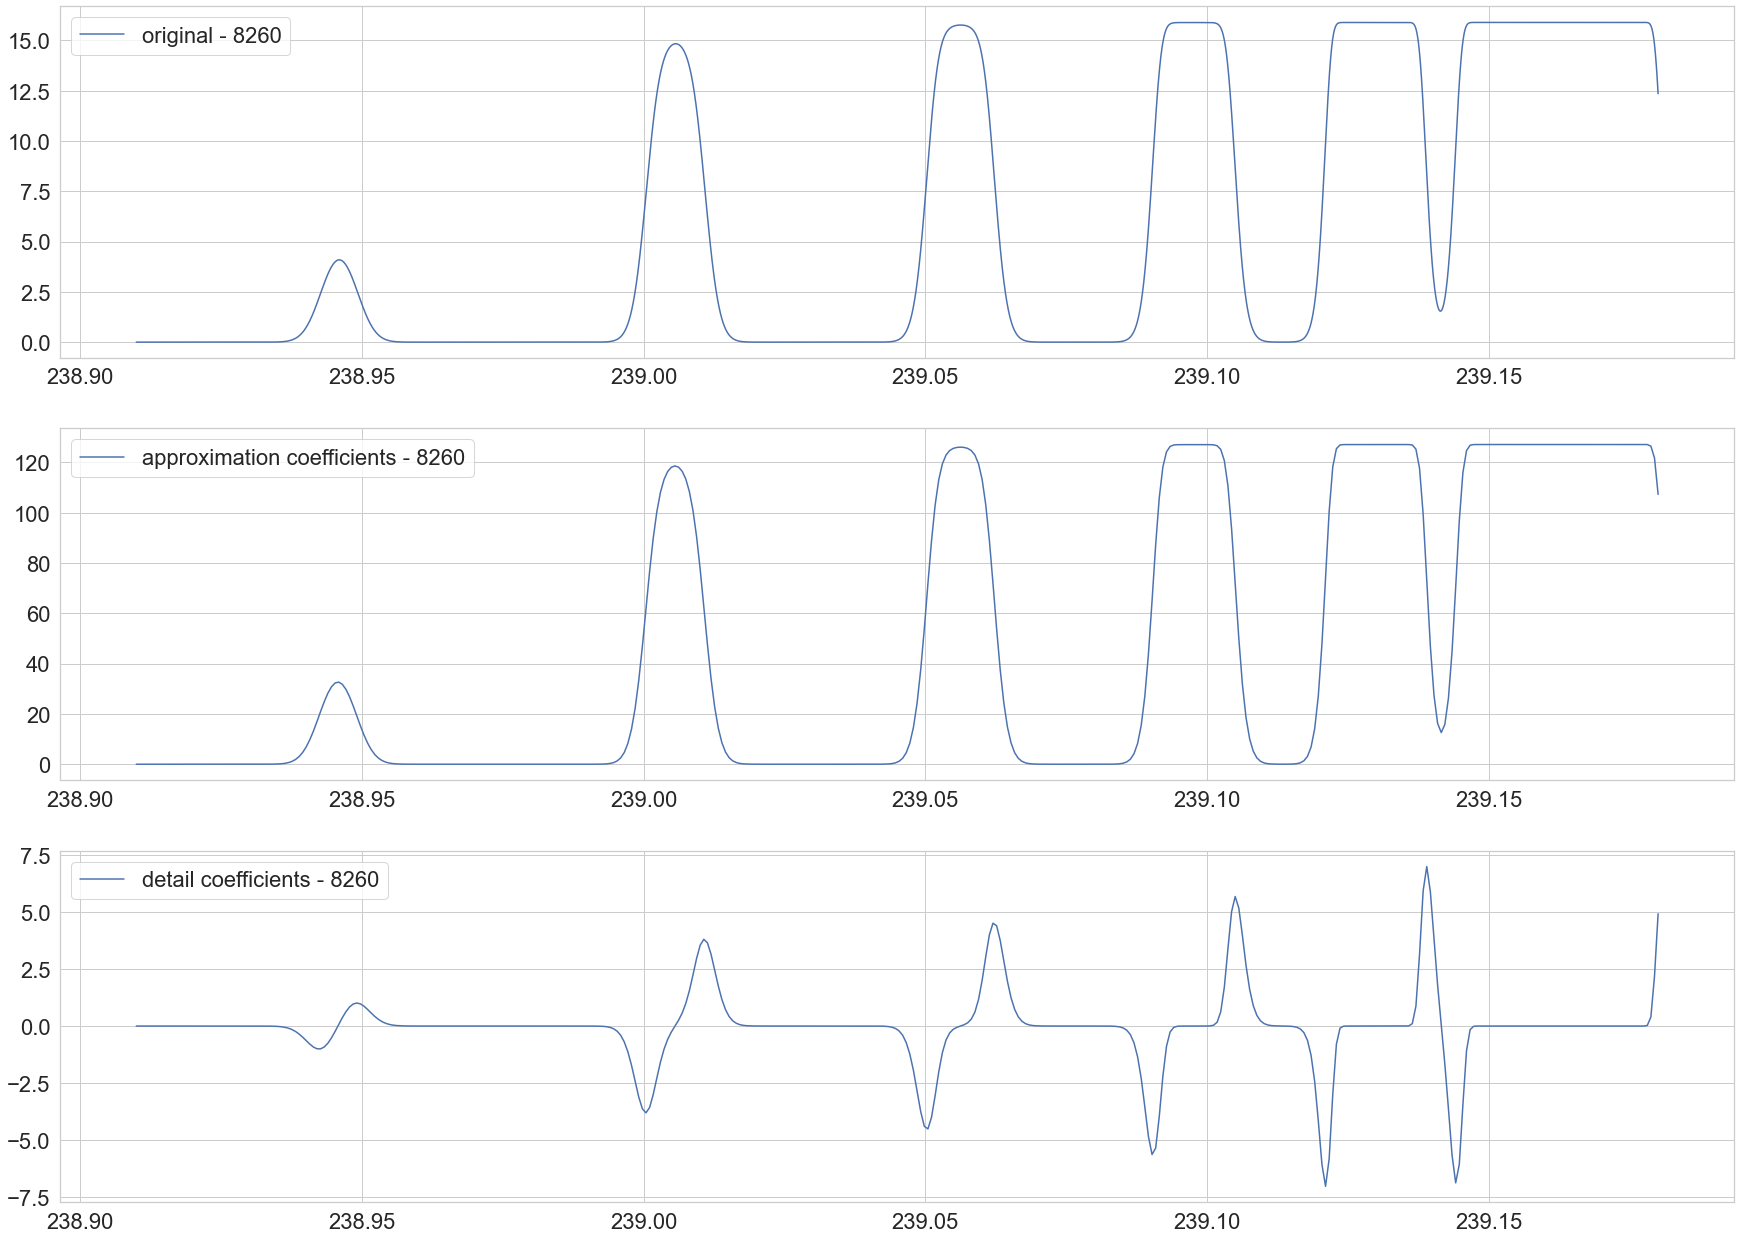

In [118]:
plt.figure(figsize=(30,22))
plt.subplot(3,1,1)
plt.plot(freq_sig[8260], signal[8260], label='original - 8260')
plt.legend()
plt.subplot(3,1,2)
plt.plot(x_new_freq, approx_coeffs[8260], label='approximation coefficients - 8260')
plt.legend()
plt.subplot(3,1,3)
plt.plot(x_new_freq, detail_coeffs[8260], label='detail coefficients - 8260')
plt.legend()
# save the subplots in a pdf file
plt.savefig(GENERATED_FILES_OUTPUT + 'dwt_signal_8260.pdf', dpi=15000)


In [119]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (20000, 422) labels_shape:  (20000, 5)


In [120]:
# drop the tcmb column
# labels_.drop(columns=['tcmb'], inplace=True)

In [121]:
df = pd.DataFrame(approx_coeffs)
df.head()

0          1          2          3          4          5    \
0  110.095832  60.089323  27.236222  10.446729   3.451826   0.993904   
1   32.193507  34.262375  35.193661  34.965266  33.581754  31.082299   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

         6          7             8             9    ...         412  \
0   0.250822   0.055608  1.083932e-02  1.858059e-03  ...    0.000000   
1  27.582363  23.321228  1.867262e+01  1.408775e+01  ...    0.000000   
2   0.000000   0.000000  3.166217e-14  1.662975e-13  ...  277.769133   
3   0.000000   0.000000  0.000000e+00  0.000000e+00  ...    0.000000   
4   0.000000   0.000000  0.000000e+00  0.000000e+00  ...    0.000000   

          413        414        415        416        417        418  \
0    0.000000    0.00000   0.000000   0.000000   0.000000   0.000000   
1    0.000000    0.00000   0.000000   0.000000   0.000000   0.000000   
2  196.346476  126.73863  75.598417  42.171021  22.214057  11.126889   
3    0.000000    0.00000   0.000000   0.000000   0.000000   0.000000   
4    0.000000    0.00000   0.000000   0.000000   0.000000   0.000000   

        419       420       421  
0  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  
2  5.323843  2.439948  1.083003  
3  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000  

[5 rows x 422 columns]

In [122]:
df = pd.concat([df, labels_], axis=1)
df.head()

0          1          2          3          4          5  \
0  110.095832  60.089323  27.236222  10.446729   3.451826   0.993904   
1   32.193507  34.262375  35.193661  34.965266  33.581754  31.082299   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

           6          7             8             9  ...        417  \
0   0.250822   0.055608  1.083932e-02  1.858059e-03  ...   0.000000   
1  27.582363  23.321228  1.867262e+01  1.408775e+01  ...   0.000000   
2   0.000000   0.000000  3.166217e-14  1.662975e-13  ...  22.214057   
3   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   0.000000   
4   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   0.000000   

         418       419       420       421      fwhm          ntot      size  \
0   0.000000  0.000000  0.000000  0.000000  5.252371  4.872648e+17  0.587752   
1   0.000000  0.000000  0.000000  0.000000  8.140540  2.624419e+17  0.229623   
2  11.126889  5.323843  2.439948  1.083003  9.448813  4.311923e+16  1.009372   
3   0.000000  0.000000  0.000000  0.000000  4.483937  1.031042e+17  0.998138   
4   0.000000  0.000000  0.000000  0.000000  2.184235  1.521796e+17  0.250813   

          tex       vlsr  
0  121.654639   7.224510  
1  242.849318   1.162407  
2   44.772760 -35.479438  
3  327.804816  33.196577  
4  209.534300  40.915396  

[5 rows x 427 columns]

In [123]:
df.shape

(20000, 427)

In [124]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0          1          2          3          4          5  \
0  110.095832  60.089323  27.236222  10.446729   3.451826   0.993904   
1   32.193507  34.262375  35.193661  34.965266  33.581754  31.082299   
2    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

           6          7             8             9  ...        417  \
0   0.250822   0.055608  1.083932e-02  1.858059e-03  ...   0.000000   
1  27.582363  23.321228  1.867262e+01  1.408775e+01  ...   0.000000   
2   0.000000   0.000000  3.166217e-14  1.662975e-13  ...  22.214057   
3   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   0.000000   
4   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   0.000000   

         418       419       420       421      fwhm       ntot      size  \
0   0.000000  0.000000  0.000000  0.000000  5.252371  17.687765  0.587752   
1   0.000000  0.000000  0.000000  0.000000  8.140540  17.419033  0.229623   
2  11.126889  5.323843  2.439948  1.083003  9.448813  16.634671  1.009372   
3   0.000000  0.000000  0.000000  0.000000  4.483937  17.013277  0.998138   
4   0.000000  0.000000  0.000000  0.000000  2.184235  17.182356  0.250813   

          tex       vlsr  
0  121.654639   7.224510  
1  242.849318   1.162407  
2   44.772760 -35.479438  
3  327.804816  33.196577  
4  209.534300  40.915396  

[5 rows x 427 columns]

In [125]:
X = df.iloc[:, :422]
y = df.iloc[:, -5:]

In [126]:
X

0             1             2             3          4    \
0      1.100958e+02  6.008932e+01  2.723622e+01  1.044673e+01   3.451826   
1      3.219351e+01  3.426238e+01  3.519366e+01  3.496527e+01  33.581754   
2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
3      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
4      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
...             ...           ...           ...           ...        ...   
19995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
19996  6.706916e-10  5.798803e-09  4.539186e-08  3.216963e-07   0.000002   
19997  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
19998  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
19999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   

             5          6          7             8             9    ...  \
0       0.993904   0.250822   0.055608  1.083932e-02  1.858059e-03  ...   
1      31.082299  27.582363  23.321228  1.867262e+01  1.408775e+01  ...   
2       0.000000   0.000000   0.000000  3.166217e-14  1.662975e-13  ...   
3       0.000000   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   
4       0.000000   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   
...          ...        ...        ...           ...           ...  ...   
19995   0.000000   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   
19996   0.000012   0.000063   0.000300  1.295367e-03  5.057497e-03  ...   
19997   0.000000   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   
19998   0.000000   0.000000   0.000000  0.000000e+00  4.021436e-14  ...   
19999   0.000000   0.000000   0.000000  0.000000e+00  0.000000e+00  ...   

              412         413         414        415        416        417  \
0        0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
1        0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
2      277.769133  196.346476  126.738630  75.598417  42.171021  22.214057   
3        0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
4        0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
...           ...         ...         ...        ...        ...        ...   
19995    0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
19996    0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
19997    0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
19998    0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
19999   13.418546   13.418615   13.418684  13.418752  13.418821  13.418890   

             418        419        420        421  
0       0.000000   0.000000   0.000000   0.000000  
1       0.000000   0.000000   0.000000   0.000000  
2      11.126889   5.323843   2.439948   1.083003  
3       0.000000   0.000000   0.000000   0.000000  
4       0.000000   0.000000   0.000000   0.000000  
...          ...        ...        ...        ...  
19995   0.000000   0.000000   0.000000   0.000000  
19996   0.000000   0.000000   0.000000   0.000000  
19997   0.000000   0.000000   0.000000   0.000000  
19998   0.000000   0.000000   0.000000   0.000000  
19999  13.418958  13.419027  13.419096  13.419163  

[20000 rows x 422 columns]

In [127]:
y

fwhm       ntot      size         tex       vlsr
0      5.252371  17.687765  0.587752  121.654639   7.224510
1      8.140540  17.419033  0.229623  242.849318   1.162407
2      9.448813  16.634671  1.009372   44.772760 -35.479438
3      4.483937  17.013277  0.998138  327.804816  33.196577
4      2.184235  17.182356  0.250813  209.534300  40.915396
...         ...        ...       ...         ...        ...
19995  1.494384  16.945493  0.602305  334.830154 -23.196229
19996  5.977481  16.493072  1.029788   71.743710 -14.831523
19997  1.145120  16.021229  0.138916  356.601981 -12.235278
19998  3.539644  16.573260  0.270246   31.340564 -15.496898
19999  7.438864  17.351543  0.106175   73.509543 -49.789945

[20000 rows x 5 columns]

#### split the data into the training and test set

In [128]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (14000, 422) 
 y_train shape:  (14000, 5) 
 X_test shape:  (6000, 422) 
 y_test shape:  (6000, 5)


In [129]:
# get the original data indices for the test data and save them in a csv file
testing_data_indices = pd.DataFrame(X_test.index)
testing_data_indices.to_csv(PARAMETERS_OUTPUT + "testing_data_indices.csv")

In [130]:
# y_train['ntot'] =  np.array(10**y_train['ntot'])
# y_train.head()

In [131]:
# get the distribution of the ntot column in the training data
# plt.figure(figsize=(10,6))
# sns.distplot(y_train['ntot'], bins=100)

In [132]:
# normalize the data
# X_train_norm = (X_train - X_train.mean()) / X_train.std()
# X_test_norm = (X_test - X_test.mean()) / X_test.std()

# y_train_norm = (y_train - y_train.mean()) / y_train.std()
# y_test_norm = (y_test - y_test.mean()) / y_test.std()

## 1. Multioutput Regressor - RF

In [133]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))


# from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        n_jobs=-1,
#        verbose=2
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700building tree 2 of 700
building tree 8 of 700

building tree 4 of 700
building tree 5 of 700
building tree 7 of 700
building tree 3 of 700
building tree 1 of 700
building tree 12 of 700building tree 11 of 700

building tree 10 of 700
building tree 13 of 700building tree 9 of 700

building tree 15 of 700
building tree 16 of 700
building tree 14 of 700
building tree 17 of 700
building tree 20 of 700
building tree 19 of 700
building tree 18 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 31 of 700
building tree 29 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s


building tree 35 of 700
building tree 36 of 700building tree 37 of 700

building tree 34 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 48 of 700
building tree 47 of 700
building tree 51 of 700
building tree 49 of 700
building tree 50 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73 of 700
building tree 74 of 700
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s


building tree 159 of 700
building tree 160 of 700
building tree 162 of 700
building tree 163 of 700
building tree 161 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 181 of 700
building tree 180 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 194 of 700building tree 195 of 700

building tree 193 of 700
building tree 196 of 700
building tree 197 of 700
building tree 198 of 700


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.8s


building tree 362 of 700
building tree 363 of 700
building tree 364 of 700
building tree 366 of 700
building tree 365 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 389 of 700
building tree 388 of 700
building tree 391 of 700
building tree 390 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700
building tree 398 of 700
building tree 399 of 700
building tree 401 of 700
building tree 400 of 700


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   22.4s


building tree 642 of 700
building tree 641 of 700
building tree 643 of 700
building tree 644 of 700
building tree 645 of 700
building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 653 of 700
building tree 655 of 700
building tree 654 of 700
building tree 652 of 700
building tree 656 of 700
building tree 663 of 700
building tree 657 of 700building tree 658 of 700
building tree 660 of 700
building tree 659 of 700

building tree 662 of 700
building tree 661 of 700
building tree 664 of 700
building tree 665 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 670 of 700
building tree 671 of 700
building tree 669 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700
building tree 679 of 700
building tree 680 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 1 of 700
building tree 8 of 700
building tree 7 of 700
building tree 4 of 700
building tree 9 of 700
building tree 12 of 700
building tree 11 of 700
building tree 13 of 700
building tree 10 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s


building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 54 of 700
building tree 53 of 700
building tree 55 of 700
building tree 52 of 700
building tree 56 of 700
building tree 57 of 700building tree 58 of 700

building tree 59 of 700
building tree 62 of 700
building tree 60 of 700
building tree 61 of 700
building tree 64 of 700
building tree 63 of 700
building tree 65 of 700
building tree 67 of 700
building tree 66 of 700
building tree 68 of 700
building tree 71 of 700
building tree 70 of 700building tree 69 of 700

building tree 72 of 700
building tree 73 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 79 of 700
building tree 77 of 700
building tree 78 of 700
building tree 80 of 700
building tree 81

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.6s


building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 185 of 700
building tree 184 of 700
building tree 186 of 700
building tree 187 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 192 of 700
building tree 194 of 700
building tree 195 of 700
building tree 197 of 700
building tree 193 of 700
building tree 196 of 700
building tree 198 of 700
building tree 201 of 700


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    8.4s


building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 377 of 700
building tree 378 of 700
building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 387 of 700building tree 386 of 700

building tree 388 of 700
building tree 389 of 700
building tree 390 of 700
building tree 391 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700
building tree 400 of 700
building tree 398 of 700
building tree 399 of 700
building tree 401 of 700
building tree 402 of 700
building tree 403 of 700
building tree 404 of 700
building tree 405 of 700
building tree 406 of 700


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   15.0s


building tree 645 of 700
building tree 646 of 700
building tree 647 of 700
building tree 648 of 700
building tree 649 of 700
building tree 652 of 700building tree 650 of 700

building tree 651 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 656 of 700
building tree 657 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 662 of 700
building tree 661 of 700
building tree 663 of 700
building tree 665 of 700
building tree 664 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 672 of 700building tree 671 of 700

building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700
building tree 679 of 700
building tree 680 of 700
building tree 681 of 700
building tree 683 of 700
building tree 684 of 700
building tree 682 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 5 of 700
building tree 4 of 700
building tree 7 of 700
building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700building tree 20 of 700

building tree 21 of 700
building tree 22 of 700
building tree 24 of 700building tree 23 of 700

building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 36 of 700
building tree 35 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s


building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 48 of 700building tree 47 of 700

building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 57 of 700
building tree 58 of 700
building tree 56 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 63 of 700
building tree 62 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 73 of 700
building tree 72 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 79 of 700
building tree 77

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s


building tree 158 of 700
building tree 159 of 700
building tree 162 of 700
building tree 157 of 700
building tree 160 of 700
building tree 161 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 175 of 700
building tree 173 of 700
building tree 174 of 700
building tree 176 of 700
building tree 180 of 700
building tree 178 of 700
building tree 177 of 700
building tree 179 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700
building tree 184 of 700
building tree 185 of 700
building tree 187 of 700
building tree 186 of 700
building tree 188 of 700
building tree 189 of 700
building tree 190 of 700
building tree 191 of 700
building tree 193 of 700building tree 192 of 700

building tree 194 of 700
building tree 195 of 700
building tree 196 of 700


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.2s


building tree 359 of 700
building tree 360 of 700
building tree 361 of 700
building tree 362 of 700
building tree 363 of 700
building tree 364 of 700
building tree 365 of 700
building tree 366 of 700
building tree 367 of 700
building tree 368 of 700
building tree 369 of 700
building tree 370 of 700
building tree 371 of 700
building tree 372 of 700
building tree 373 of 700
building tree 374 of 700
building tree 375 of 700
building tree 376 of 700
building tree 378 of 700building tree 377 of 700

building tree 379 of 700
building tree 380 of 700
building tree 381 of 700
building tree 382 of 700
building tree 383 of 700
building tree 384 of 700
building tree 385 of 700
building tree 386 of 700
building tree 387 of 700
building tree 388 of 700
building tree 389 of 700
building tree 391 of 700
building tree 390 of 700
building tree 392 of 700
building tree 393 of 700
building tree 394 of 700
building tree 395 of 700
building tree 396 of 700
building tree 397 of 700
building tree 398 of 700


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   18.2s


building tree 645 of 700
building tree 646 of 700
building tree 648 of 700
building tree 647 of 700
building tree 649 of 700
building tree 650 of 700
building tree 651 of 700
building tree 652 of 700
building tree 653 of 700
building tree 654 of 700
building tree 655 of 700
building tree 657 of 700
building tree 656 of 700
building tree 658 of 700
building tree 659 of 700
building tree 660 of 700
building tree 661 of 700
building tree 662 of 700
building tree 665 of 700
building tree 663 of 700
building tree 664 of 700
building tree 666 of 700
building tree 667 of 700
building tree 668 of 700
building tree 669 of 700
building tree 670 of 700
building tree 671 of 700
building tree 672 of 700
building tree 673 of 700
building tree 674 of 700
building tree 675 of 700
building tree 676 of 700
building tree 677 of 700
building tree 678 of 700
building tree 681 of 700
building tree 679 of 700
building tree 680 of 700
building tree 682 of 700
building tree 683 of 700
building tree 684 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 8 of 700
building tree 7 of 700
building tree 6 of 700
building tree 9 of 700
building tree 12 of 700
building tree 13 of 700
building tree 11 of 700
building tree 10 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 22 of 700
building tree 20 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 37 of 700building tree 35 of 700

building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 47 of 700building tree 45 of 700

building tree 34 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


building tree 49 of 700
building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 50 of 700
building tree 52 of 700
building tree 54 of 700
building tree 56 of 700
building tree 58 of 700
building tree 60 of 700
building tree 62 of 700
building tree 63 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700building tree 71 of 700

building tree 73 of 700
building tree 64 of 700
building tree 75 of 700
building tree 77 of 700
building tree 66 of 700
building tree 68 of 700
building tree 70 of 700
building tree 72 of 700
building tree 76 of 700
building tree 74 of 700
building tree 78 of 700
building tree 79 of 700
building tree 81 of 700
building tree 83 of 700
building tree 80 of 700
building tree 91 of 700building tree 85 of 700
building tree 87 of 700

building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 84 of 700
building tree 86

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.6s


building tree 288 of 700
building tree 290 of 700
building tree 292 of 700
building tree 301 of 700
building tree 294 of 700
building tree 296 of 700
building tree 298 of 700
building tree 300 of 700
building tree 303 of 700
building tree 305 of 700
building tree 302 of 700
building tree 307 of 700
building tree 309 of 700
building tree 304 of 700
building tree 311 of 700
building tree 306 of 700
building tree 315 of 700
building tree 313 of 700
building tree 308 of 700
building tree 310 of 700
building tree 312 of 700
building tree 319 of 700building tree 317 of 700

building tree 316 of 700
building tree 321 of 700
building tree 314 of 700
building tree 325 of 700
building tree 323 of 700
building tree 320 of 700
building tree 318 of 700
building tree 327 of 700
building tree 322 of 700
building tree 329 of 700
building tree 331 of 700
building tree 324 of 700
building tree 326 of 700
building tree 328 of 700
building tree 330 of 700
building tree 335 of 700
building tree 333 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:   14.4s remaining:    0.3s


building tree 697 of 700building tree 699 of 700
building tree 698 of 700

building tree 700 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 3 of 700
building tree 4 of 700building tree 8 of 700building tree 7 of 700building tree 6 of 700



building tree 5 of 700
building tree 9 of 700
building tree 13 of 700
building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 16 of 700
building tree 14 of 700
building tree 15 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 37 of 700
building tree 35 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 34 of 700
building tree 38 of 700
building tree 47 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


building tree 49 of 700
building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 50 of 700
building tree 61 of 700
building tree 63 of 700
building tree 52 of 700
building tree 54 of 700
building tree 56 of 700
building tree 58 of 700
building tree 60 of 700
building tree 62 of 700
building tree 64 of 700
building tree 65 of 700
building tree 69 of 700building tree 67 of 700

building tree 71 of 700
building tree 73 of 700
building tree 66 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 68 of 700
building tree 70 of 700
building tree 72 of 700
building tree 74 of 700
building tree 76 of 700
building tree 78 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 89 of 700
building tree 87 of 700
building tree 91 of 700
building tree 82 of 700
building tree 93 of 700
building tree 95 of 700
building tree 84

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.3s


building tree 297 of 700
building tree 290 of 700
building tree 292 of 700
building tree 299 of 700
building tree 294 of 700
building tree 301 of 700
building tree 303 of 700
building tree 296 of 700
building tree 298 of 700
building tree 300 of 700
building tree 304 of 700
building tree 307 of 700
building tree 305 of 700
building tree 302 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 308 of 700
building tree 306 of 700
building tree 310 of 700
building tree 315 of 700
building tree 317 of 700
building tree 312 of 700
building tree 319 of 700
building tree 314 of 700
building tree 316 of 700
building tree 318 of 700
building tree 320 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 329 of 700
building tree 322 of 700
building tree 327 of 700
building tree 324 of 700
building tree 331 of 700
building tree 333 of 700
building tree 335 of 700
building tree 326 of 700
building tree 330 of 700


[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   12.3s


building tree 692 of 700
building tree 693 of 700
building tree 694 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   12.5s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [134]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)
# predict on the training data
y_multirf_pred_train = regr_multirf.predict(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(

In [135]:
# regr_multirf.score(X_test, y_test)
# regr_multirf.score(X_train, y_train)
print('Multioutput Regressor + on testing data: ', regr_multirf.score(X_test, y_test), '\n', 'Multioutput Regressor + on training data: ', regr_multirf.score(X_train, y_train))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(

Multioutput Regressor + on testing data:  0.8219325257405563 
 Multioutput Regressor + on training data:  0.970106104374182


[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.9s finished


### Metrics

In [136]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score
            # "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        # if metric == "msle":
        #     return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    # def _mean_squared_log_error(self, y_true, y_pred):
    #     return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))

In [137]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred).round(4))

Multirf  mae:  11.6019
Multirf  mse:  990.0561
Multirf  rmse:  31.4652
Multirf  mape:  fwhm     2.5843
ntot     1.5993
size    14.9890
tex     47.2905
vlsr     1.6324
dtype: float64
Multirf  r2:  0.8219


#### Save the model

In [138]:
joblib.dump(regr_multirf, MODELS_OUTPUT + "rf_model.pkl")

['../data/models/rf_model.pkl']

### save the true params used for the training set to a file

In [139]:
test_values = y_test.values
df_true_params = pd.DataFrame(test_values, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
df_true_params['ntot'] = np.array(10**df_true_params['ntot'])
df_true_params.to_csv(GENERATED_FILES_OUTPUT + "true_param_vals.csv")
df_true_params.head()

fwhm          ntot      size         tex       vlsr
10650   5.420657  6.139974e+17  0.400616  301.399418 -22.118946
2041   10.370708  2.455622e+16  0.337964  142.987261 -13.799456
8668    6.367165  4.658946e+17  1.094213  252.181259  32.416248
1114    1.573503  6.927726e+16  0.301901  196.853623 -38.256563
13902   6.817842  2.805388e+16  0.551406   49.954130  14.221030

### save the predicted parameters to a csv file 

In [140]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
param_df_rf.head()

fwhm       ntot      size         tex       vlsr
10650   5.485327  17.430059  0.447062  248.661729 -22.016424
2041   10.146253  16.502226  0.488881  195.326545 -13.858448
8668    6.404618  17.472121  1.057626  186.139006  32.459614
1114    1.537821  17.025867  0.395708  210.555287 -37.873660
13902   6.802640  16.571167  0.593443   86.552108  14.092614

In [141]:
# convert back the log to linear values 
param_df_rf['ntot'] = np.array(10**param_df_rf['ntot'])
param_df_rf.head()

fwhm          ntot      size         tex       vlsr
10650   5.485327  2.691902e+17  0.447062  248.661729 -22.016424
2041   10.146253  3.178527e+16  0.488881  195.326545 -13.858448
8668    6.404618  2.965654e+17  1.057626  186.139006  32.459614
1114    1.537821  1.061369e+17  0.395708  210.555287 -37.873660
13902   6.802640  3.725349e+16  0.593443   86.552108  14.092614

In [142]:
param_df_rf.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(6000, 5)

In [143]:
pred_para = pd.read_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_rf.csv')
true_para = pd.read_csv(GENERATED_FILES_OUTPUT + 'true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv(GENERATED_FILES_OUTPUT + 'true_param_vals_with_predicted_rf.csv')
true_para.head()

Unnamed: 0       fwhm          ntot      size         tex       vlsr    0  \
0       10650   5.420657  6.139974e+17  0.400616  301.399418 -22.118946  0.0   
1        2041  10.370708  2.455622e+16  0.337964  142.987261 -13.799456  0.0   
2        8668   6.367165  4.658946e+17  1.094213  252.181259  32.416248  0.0   
3        1114   1.573503  6.927726e+16  0.301901  196.853623 -38.256563  0.0   
4       13902   6.817842  2.805388e+16  0.551406   49.954130  14.221030  0.0   

   Unnamed: 0       fwhm          ntot      size         tex       vlsr  
0       10650   5.485327  2.691902e+17  0.447062  248.661729 -22.016424  
1        2041  10.146253  3.178527e+16  0.488881  195.326545 -13.858448  
2        8668   6.404618  2.965654e+17  1.057626  186.139006  32.459614  
3        1114   1.537821  1.061369e+17  0.395708  210.555287 -37.873660  
4       13902   6.802640  3.725349e+16  0.593443   86.552108  14.092614

### Predicted vs True values plots

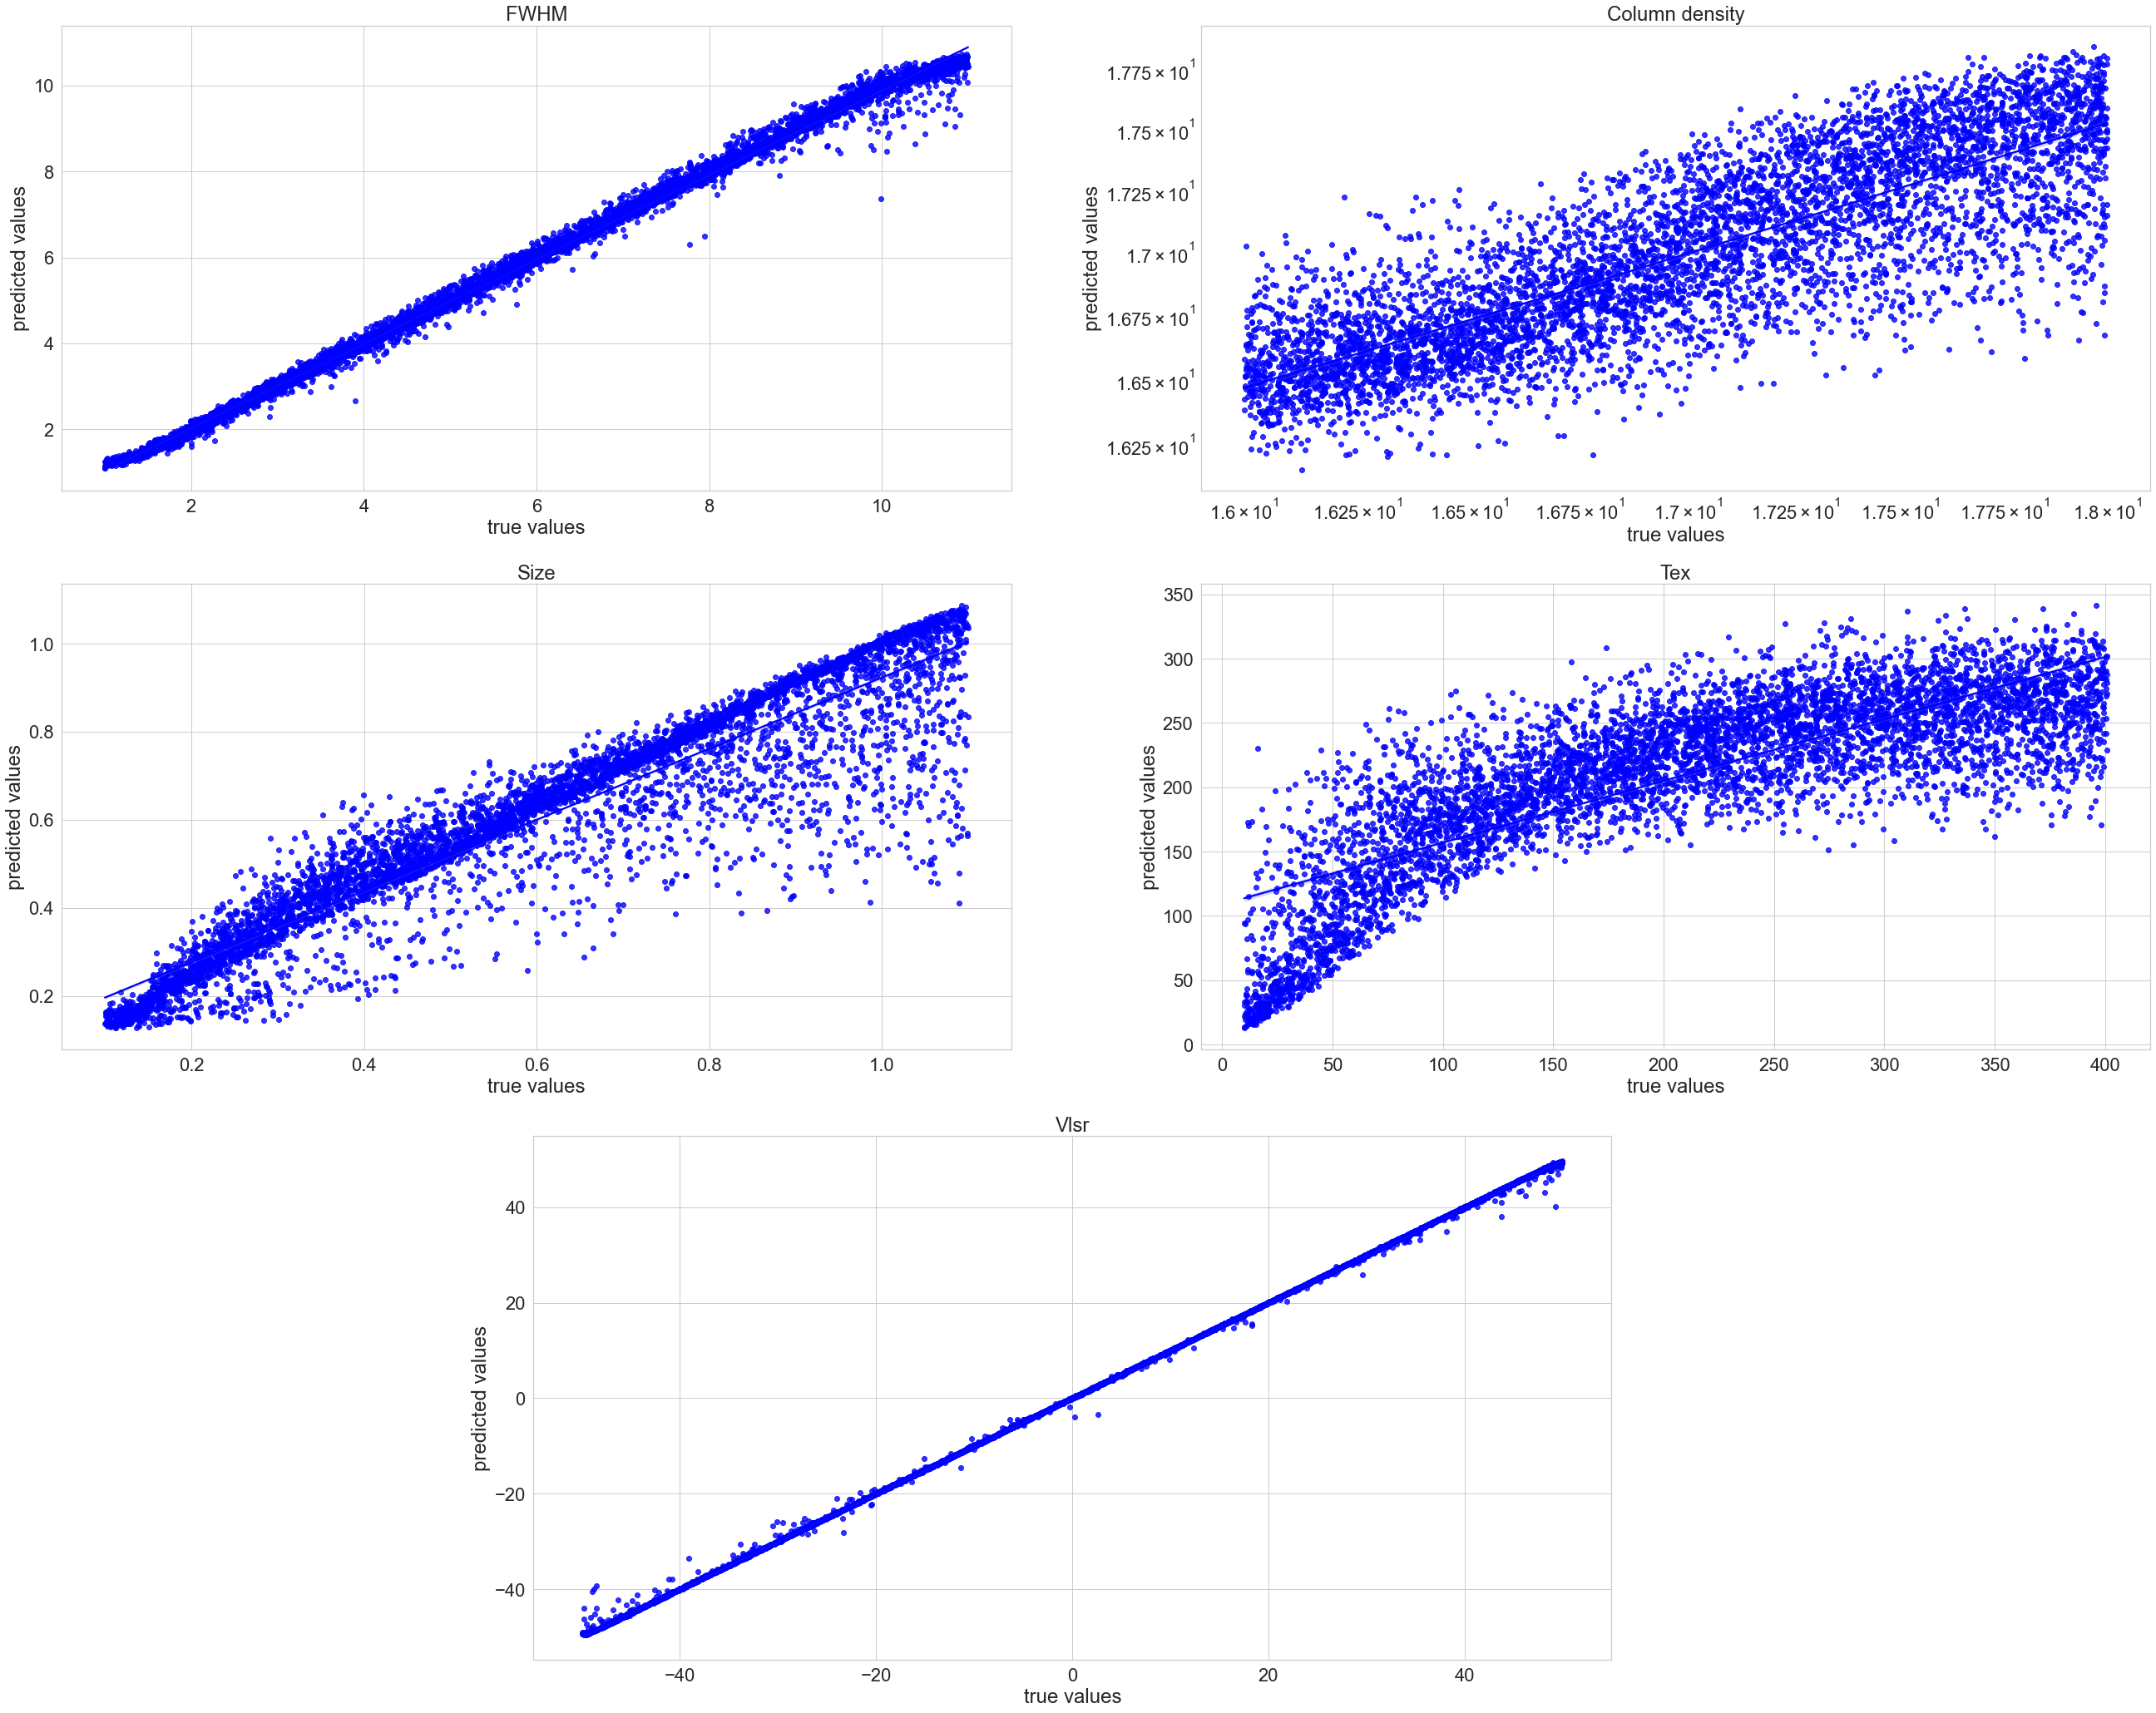

In [144]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig(GENERATED_FILES_OUTPUT + "pred_true_RF.pdf", dpi=15000)
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [145]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf['ntot'] = np.array(10**pred_param_rf['ntot'])
pred_param_rf.head()

fwhm          ntot      size         tex       vlsr
0   5.485327  2.691902e+17  0.447062  248.661729 -22.016424
1  10.146253  3.178527e+16  0.488881  195.326545 -13.858448
2   6.404618  2.965654e+17  1.057626  186.139006  32.459614
3   1.537821  1.061369e+17  0.395708  210.555287 -37.873660
4   6.802640  3.725349e+16  0.593443   86.552108  14.092614

### Residuals 3D plot -  Random Forest Regressor

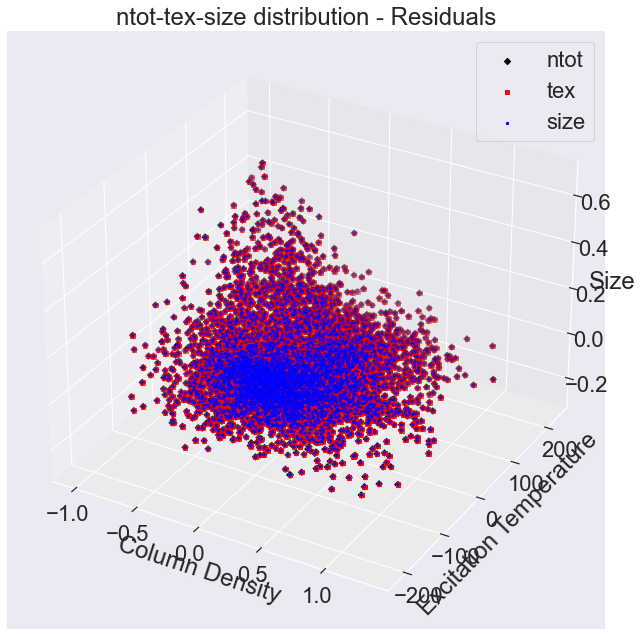

In [146]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

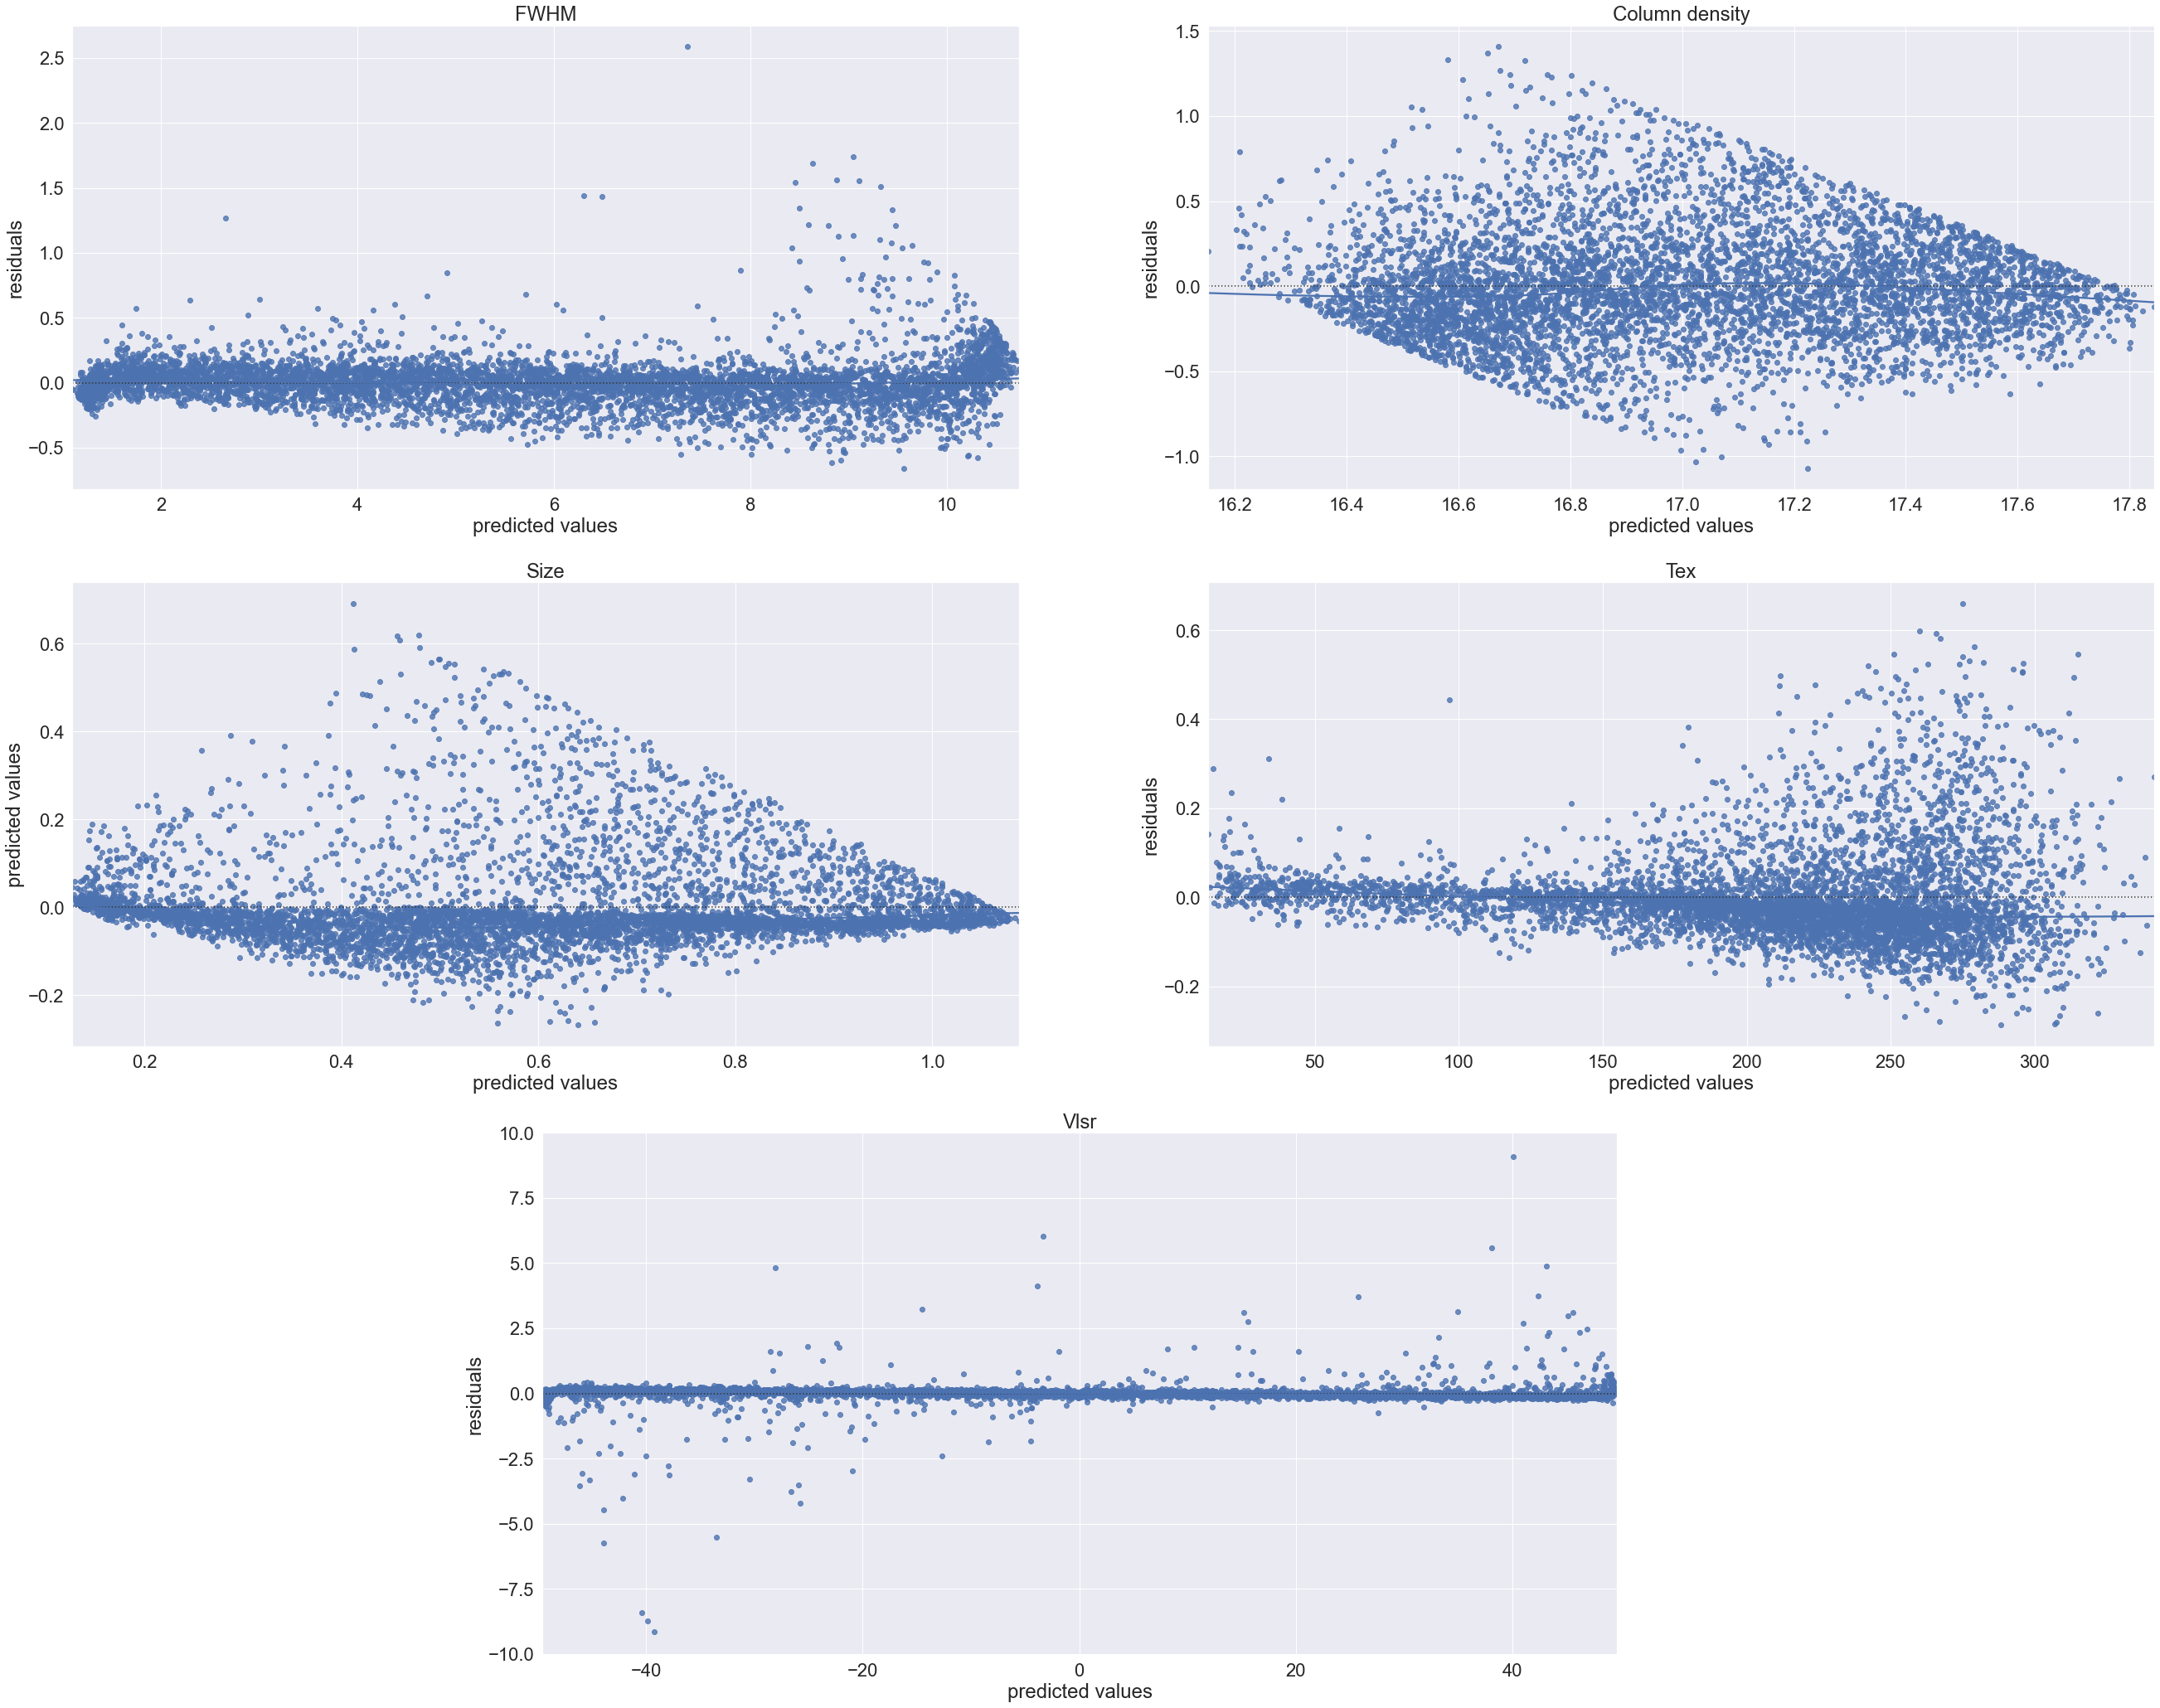

In [147]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig(GENERATED_FILES_OUTPUT + "residuals_RF.pdf", dpi=15000)
plt.show()

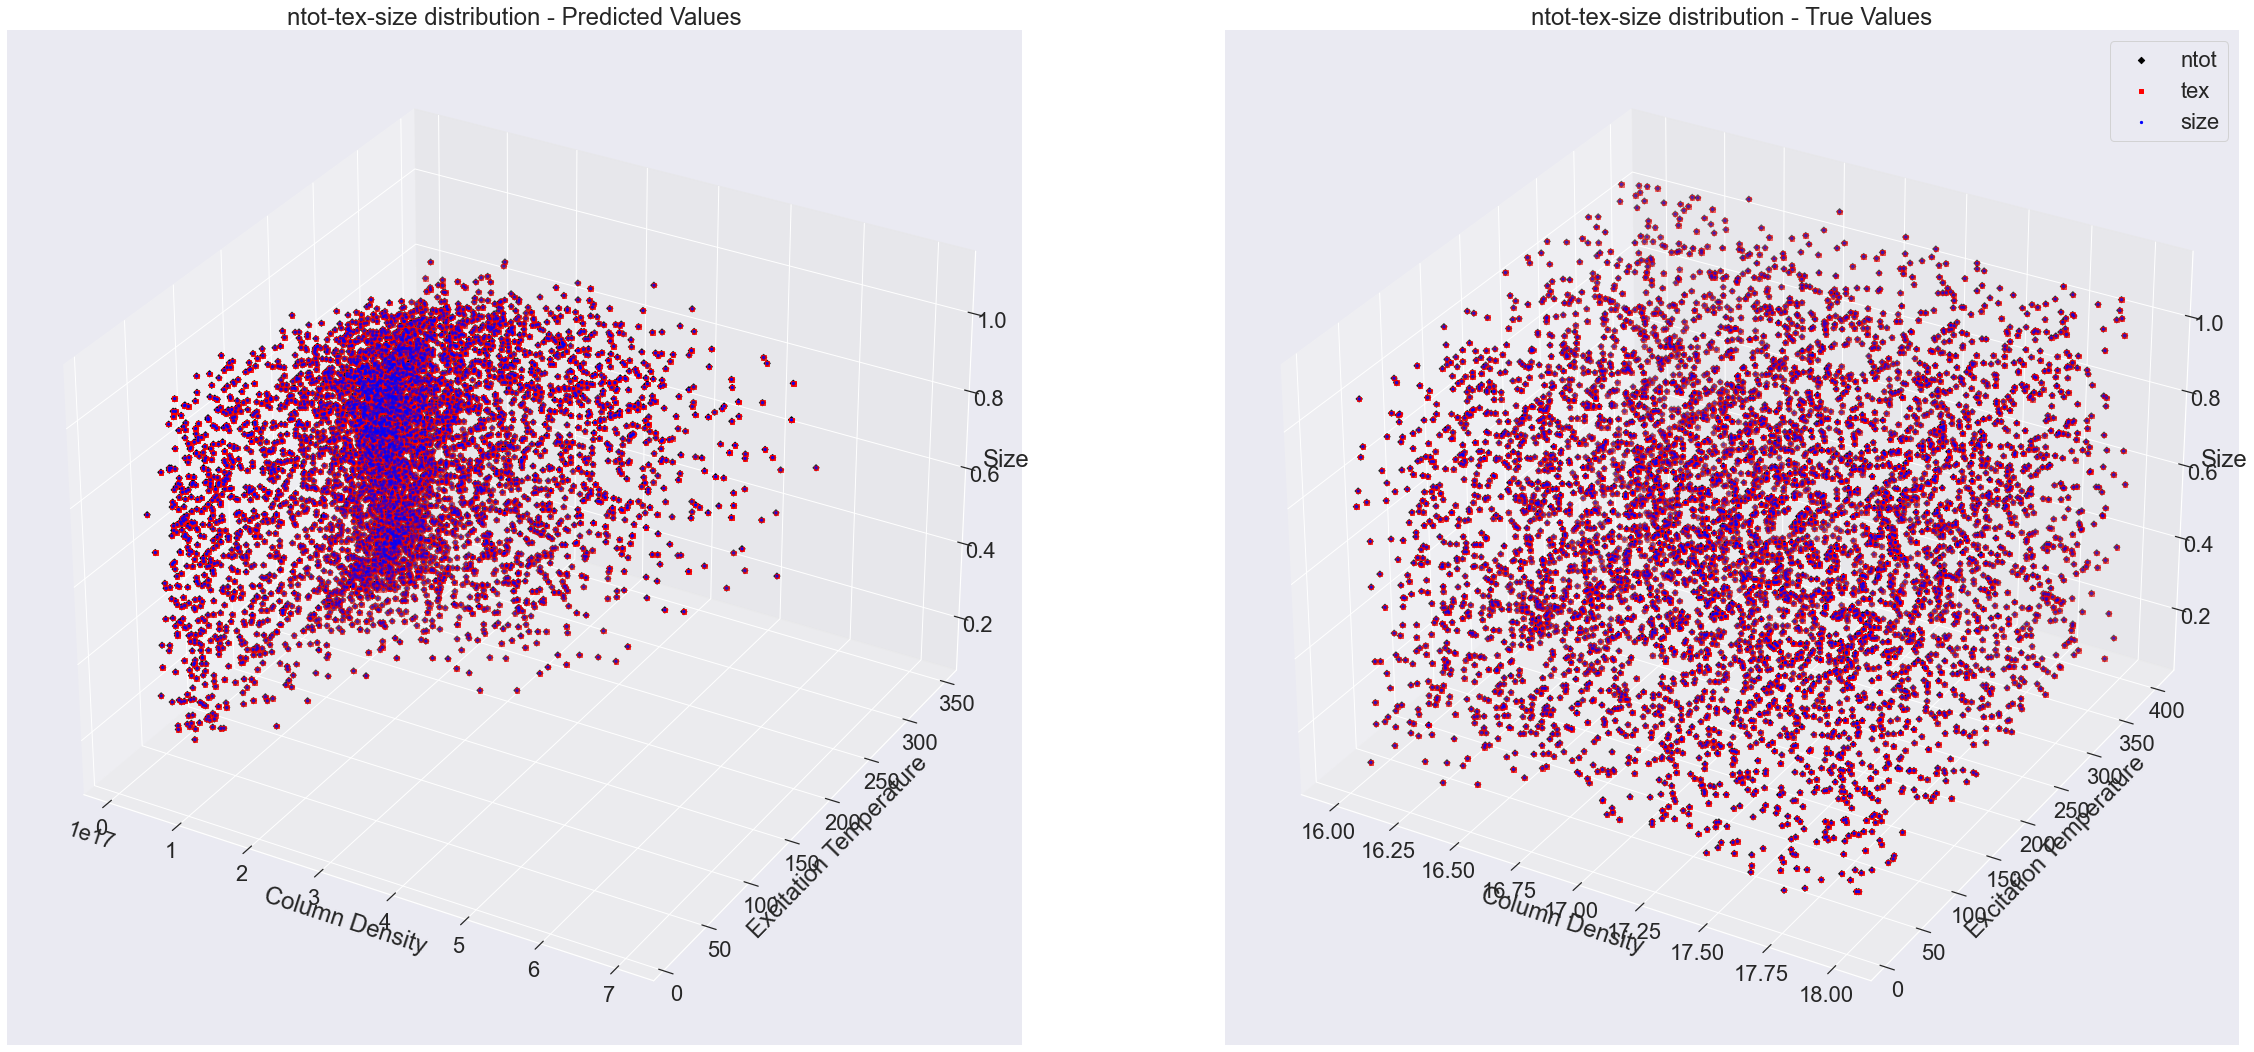

In [148]:
fig = plt.figure(figsize=(40, 25))
plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=5.0)
# plt.setp(ax.get_xticklabels(),   rotation=30, horizontalalignment='right', fontsize='x-small')
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")


plt.savefig(GENERATED_FILES_OUTPUT + "scatter3D_pred_true_RF.pdf", dpi=15000)
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [149]:
# multirf_model.get_params().keys()

In [150]:
# multirf_model = MultiOutputRegressor(
#     RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
# )

# multrf_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__min_samples_split=np.arange(2, 10, 2),
#     estimator__min_samples_leaf=np.arange(1, 5, 1),
#     # estimator__number_of_iterations=np.arange(100, 1000, 100),
#     estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
#     # estimator__criterion=["squared_error", "absolute_error"],
#     estimator__max_features=["auto", "sqrt", "log2"],
#     estimator__max_samples=np.arange(0.5, 1, 0.1),
#     estimator__bootstrap=["True", "False"]
#     )

In [151]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# regr_tuned_multirf = RandomizedSearchCV(
#     estimator=multirf_model,
#     param_distributions=multrf_hyperparameters,
#     cv=kfold,
#     verbose=2,
#     error_score="raise",
#     n_jobs=-1,
#     random_state=42,
#     return_train_score=True
# )

In [152]:
# regr_tuned_multirf.fit(X_train, y_train)

In [153]:
# regr_tuned_multirf.best_params_

In [154]:
# # best parameters from tuned model
# regr_tuned_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=500, 
#        min_samples_split=2,
#        min_samples_leaf=256,
#        max_features='auto', 
#        max_depth=30,
#        bootstrap=True,
#        verbose=5
#     )
# )

In [155]:
# hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

In [156]:
# y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [157]:
# # TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [158]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
# g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
# g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
# g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
# g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

# g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
# g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
# g3.set(title='Size', ylabel="predicted values", xlabel="true values")
# g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

# plt.savefig("data/10K_gen_files/pred_true_10K_tuned_RF.png")
# plt.show()

### Residuals - RF Tuned Model

In [159]:
# residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
# residuals_tuned_rf

In [160]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# # plot the redisual distribution using seaborn
# g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
# g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
# g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
# g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
# g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
# g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
# g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
# g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
# g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
# g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

# plt.savefig("data/10K_gen_files/residuals_tuned_RF_10K.png")
# plt.show()

## 2. XGBoost Regressor

In [161]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)
multixgb_model.fit(X_train, y_train)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7fac2493a5e0>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [162]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [163]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred).round(4))

mae : 7.9508
mse : 542.7006
rmse : 23.2959
mape : fwhm     1.6316
ntot     1.3445
size    13.5657
tex     29.4011
vlsr     3.1346
dtype: float64
r2 : 0.8781


In [164]:
# cross validation
# scores = cross_val_score(multixgb_model, X_train, y_train, cv=5)
# print("Cross validation score:%.2f", scores.mean())

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
kf_cv_scores = cross_val_score(multixgb_model, X_train, y_train, cv=kfold)
print("KFold cross validation score:%.2f", kf_cv_scores.mean())


multixgb_model.fit(X_train, y_train)
y_multixgb_pred_cv = multixgb_model.predict(X_test)
# metrics
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred_cv).round(4))

KFold cross validation score:%.2f 0.8730330284028229
mae : 7.9508
mse : 542.7006
rmse : 23.2959
mape : fwhm     1.6316
ntot     1.3445
size    13.5657
tex     29.4011
vlsr     3.1346
dtype: float64
r2 : 0.8781


### save the predicted parameters to a csv file

In [165]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
param_df_xgb['ntot'] = np.array(10**param_df_xgb['ntot'])
param_df_xgb.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_xgb.csv')

In [166]:
param_df_xgb.head()

fwhm          ntot      size         tex       vlsr
0   5.346684  4.129615e+17  0.430286  261.559723 -22.185246
1  10.454147  2.860902e+16  0.501149  197.130402 -13.481351
2   6.422562  3.327862e+17  1.042912  231.887863  32.103550
3   1.488236  1.536515e+17  0.387908  227.152985 -38.151436
4   6.834697  3.329309e+16  0.574754   29.798813  14.257041

### Save the model to a file

In [167]:
joblib.dump(multixgb_model, MODELS_OUTPUT + 'xgb_model.pkl')

['../data/models/xgb_model.pkl']

### Predicted vs True values - XGB Regressor

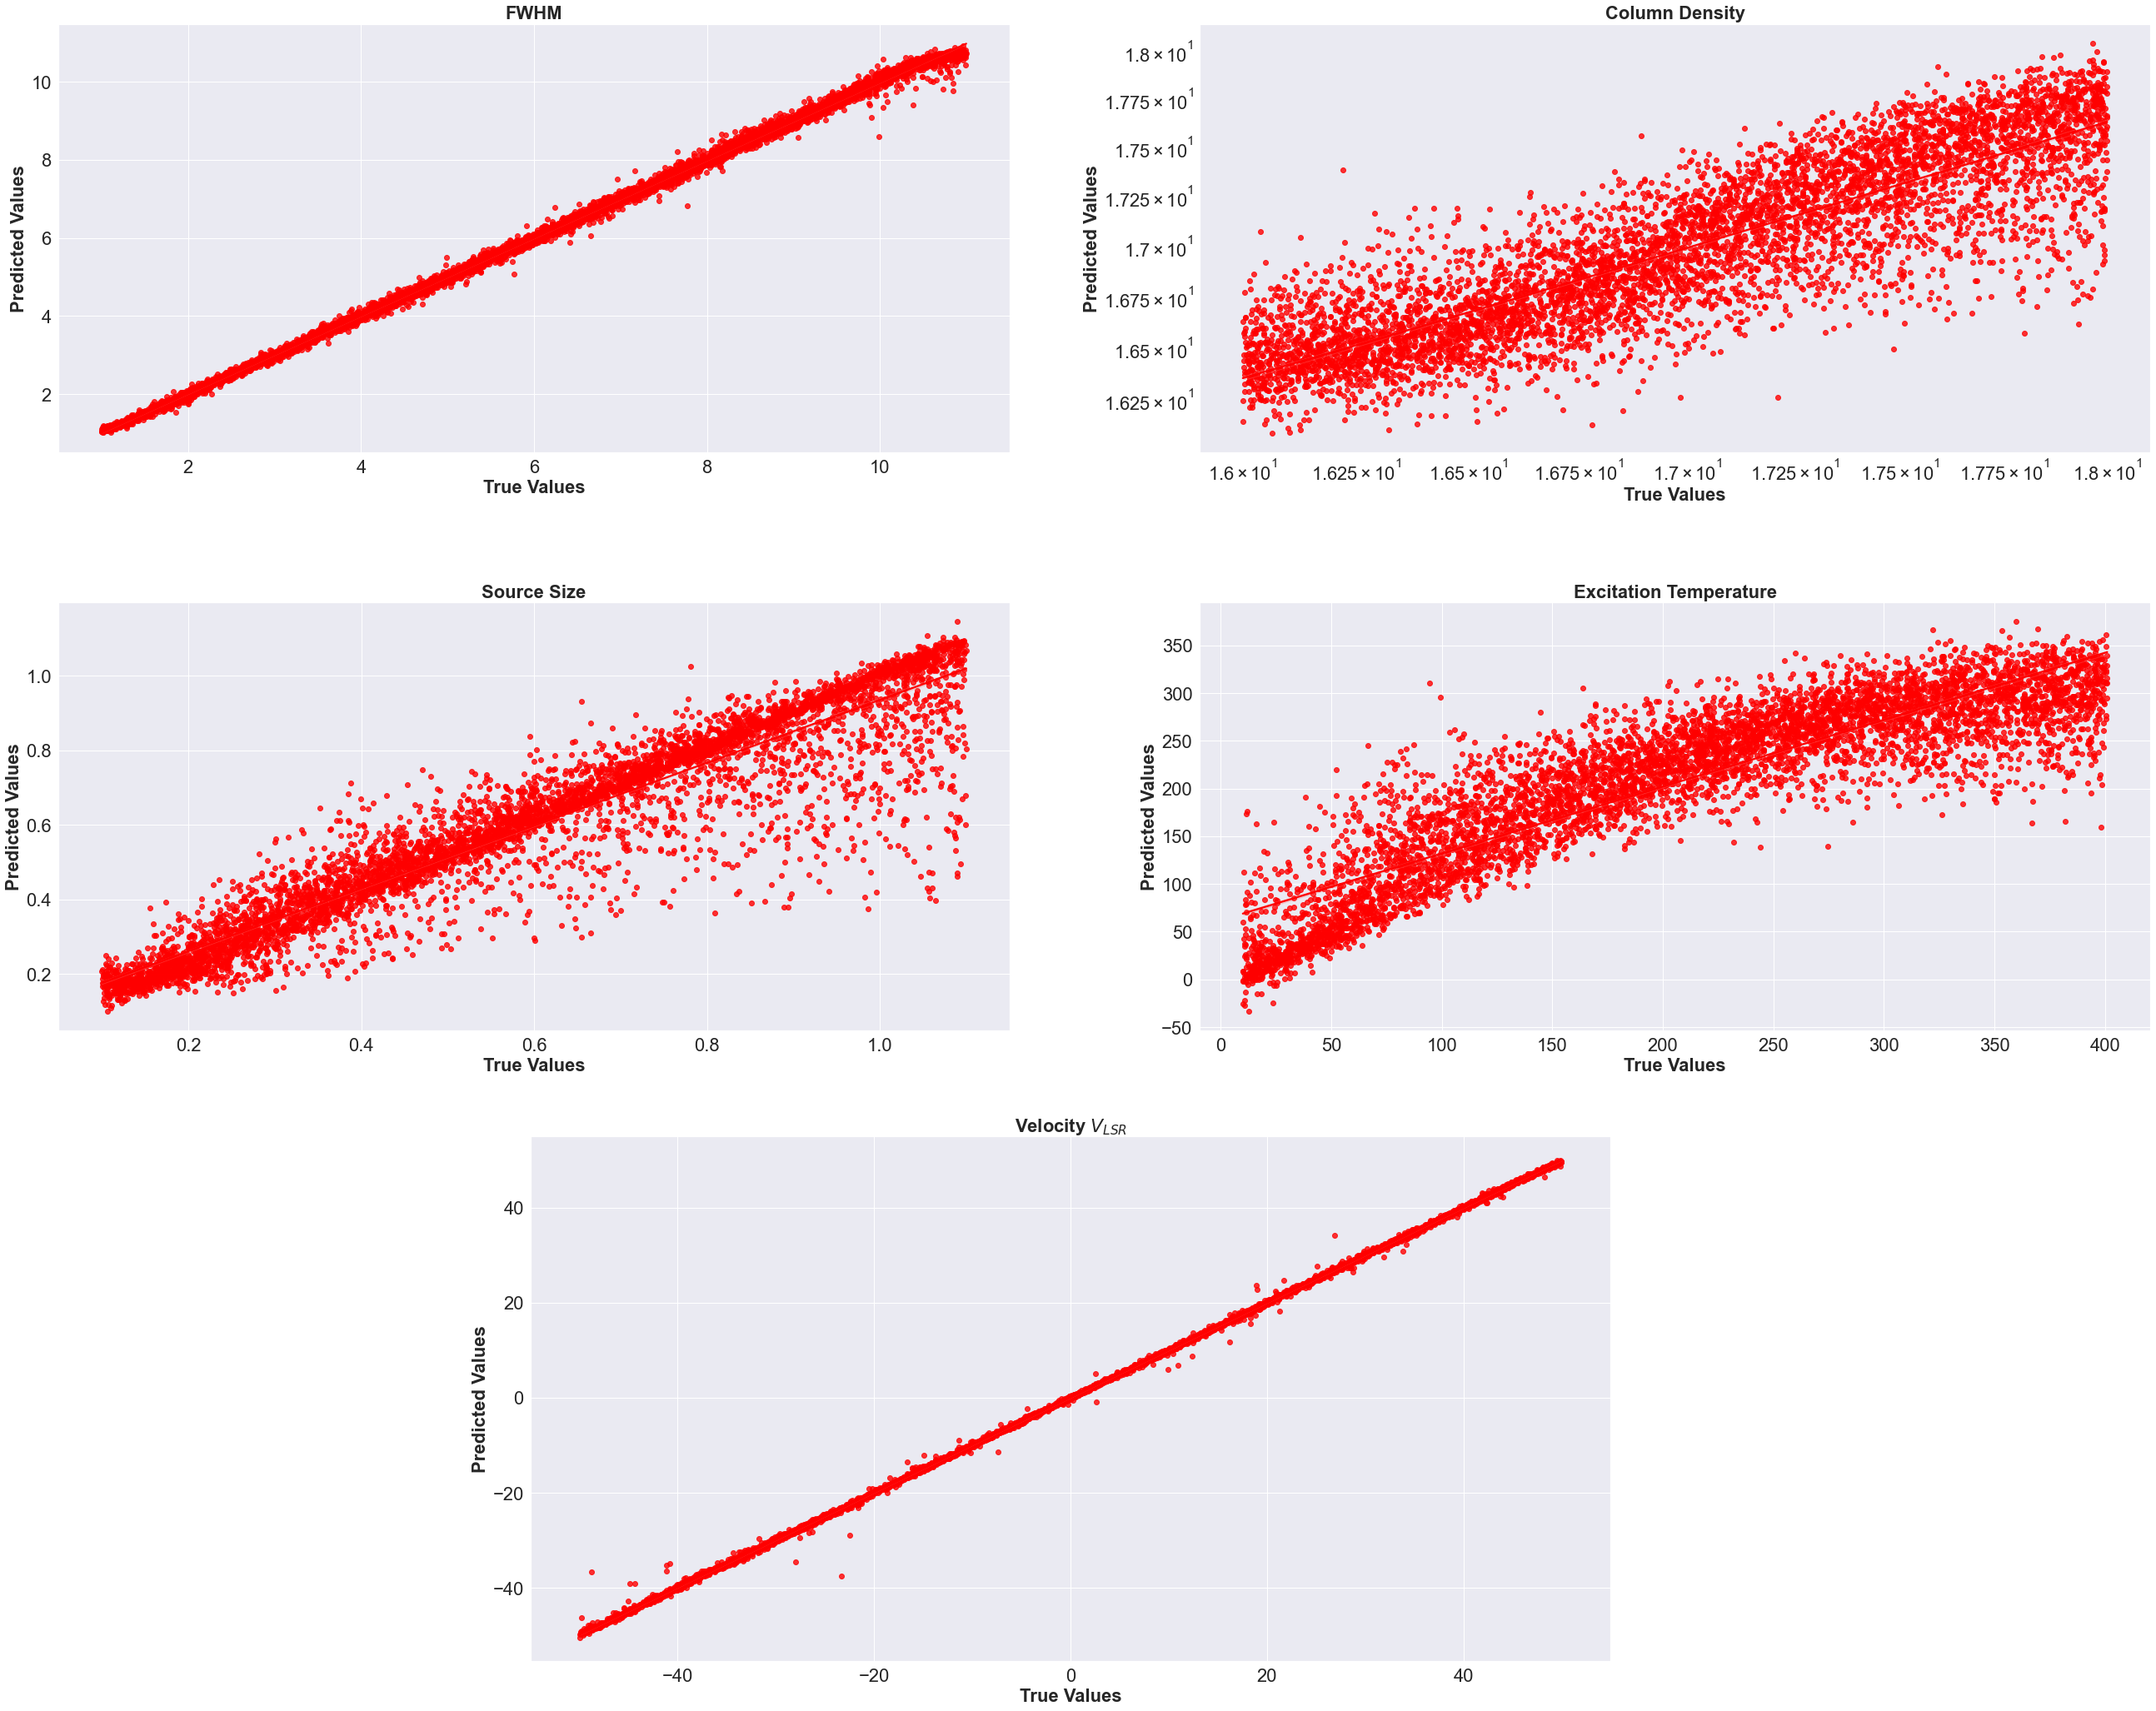

In [168]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=22)
# increase padding between subplots
plt.subplots_adjust(hspace=0.35)

# sns.set_theme(font_scale=2) 
sns.set_style("white", {'axes.grid': False})
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="Predicted Values", xlabel="True Values")
g2.set(title='Column Density', ylabel="Predicted Values", xlabel="True Values", yscale="log", xscale="log")
g3.set(title='Source Size', ylabel="Predicted Values", xlabel="True Values")
g4.set(title='Excitation Temperature', ylabel="Predicted Values", xlabel="True Values")
g5.set(title='Velocity $V_{LSR}$', ylabel="Predicted Values", xlabel="True Values")
# bold the title of the plot
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=22, weight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=22, weight='bold')
    ax.set_title(ax.get_title(), fontsize=22, weight='bold')
    ax.tick_params(labelsize=22, length=5, width=2)
    # ax.tick_params(axis='x', labelrotation=45)
    
plt.savefig(GENERATED_FILES_OUTPUT + "pred_true_10K_XGB.pdf", dpi=15000)
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [169]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb['ntot'] = np.array(10**pred_param_xgb['ntot'])
pred_param_xgb.head()

fwhm          ntot      size         tex       vlsr
0   5.346684  4.129615e+17  0.430286  261.559723 -22.185246
1  10.454147  2.860902e+16  0.501149  197.130402 -13.481351
2   6.422562  3.327862e+17  1.042912  231.887863  32.103550
3   1.488236  1.536515e+17  0.387908  227.152985 -38.151436
4   6.834697  3.329309e+16  0.574754   29.798813  14.257041

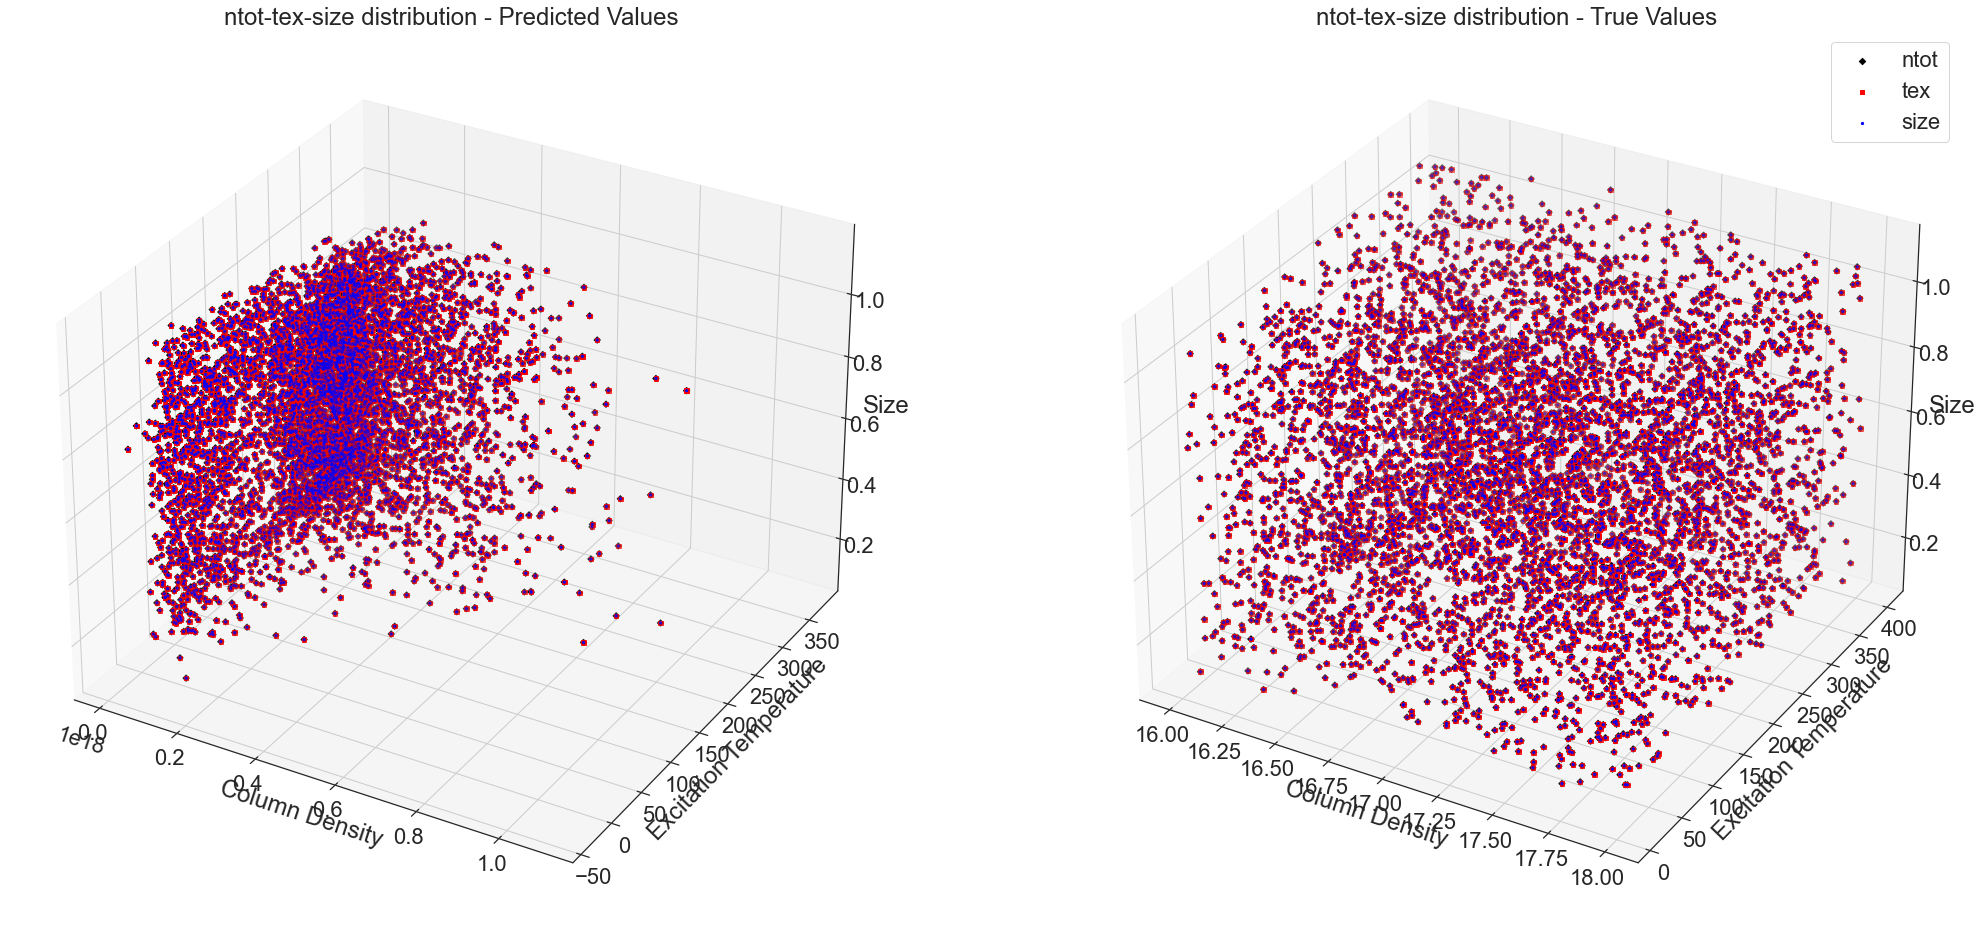

In [170]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig(GENERATED_FILES_OUTPUT + "scatter3D_pred_true_10K_XGB.pdf", dpi=15000)
plt.show()

### Residuals 3D plot - XGB Regressor

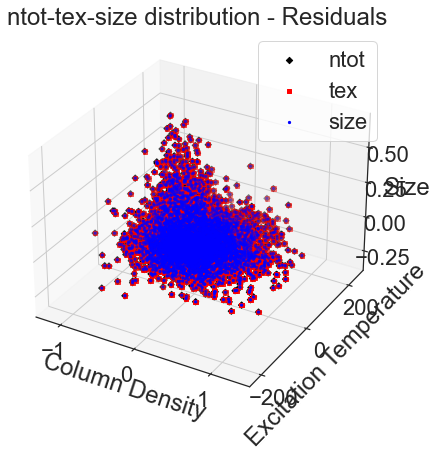

In [171]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

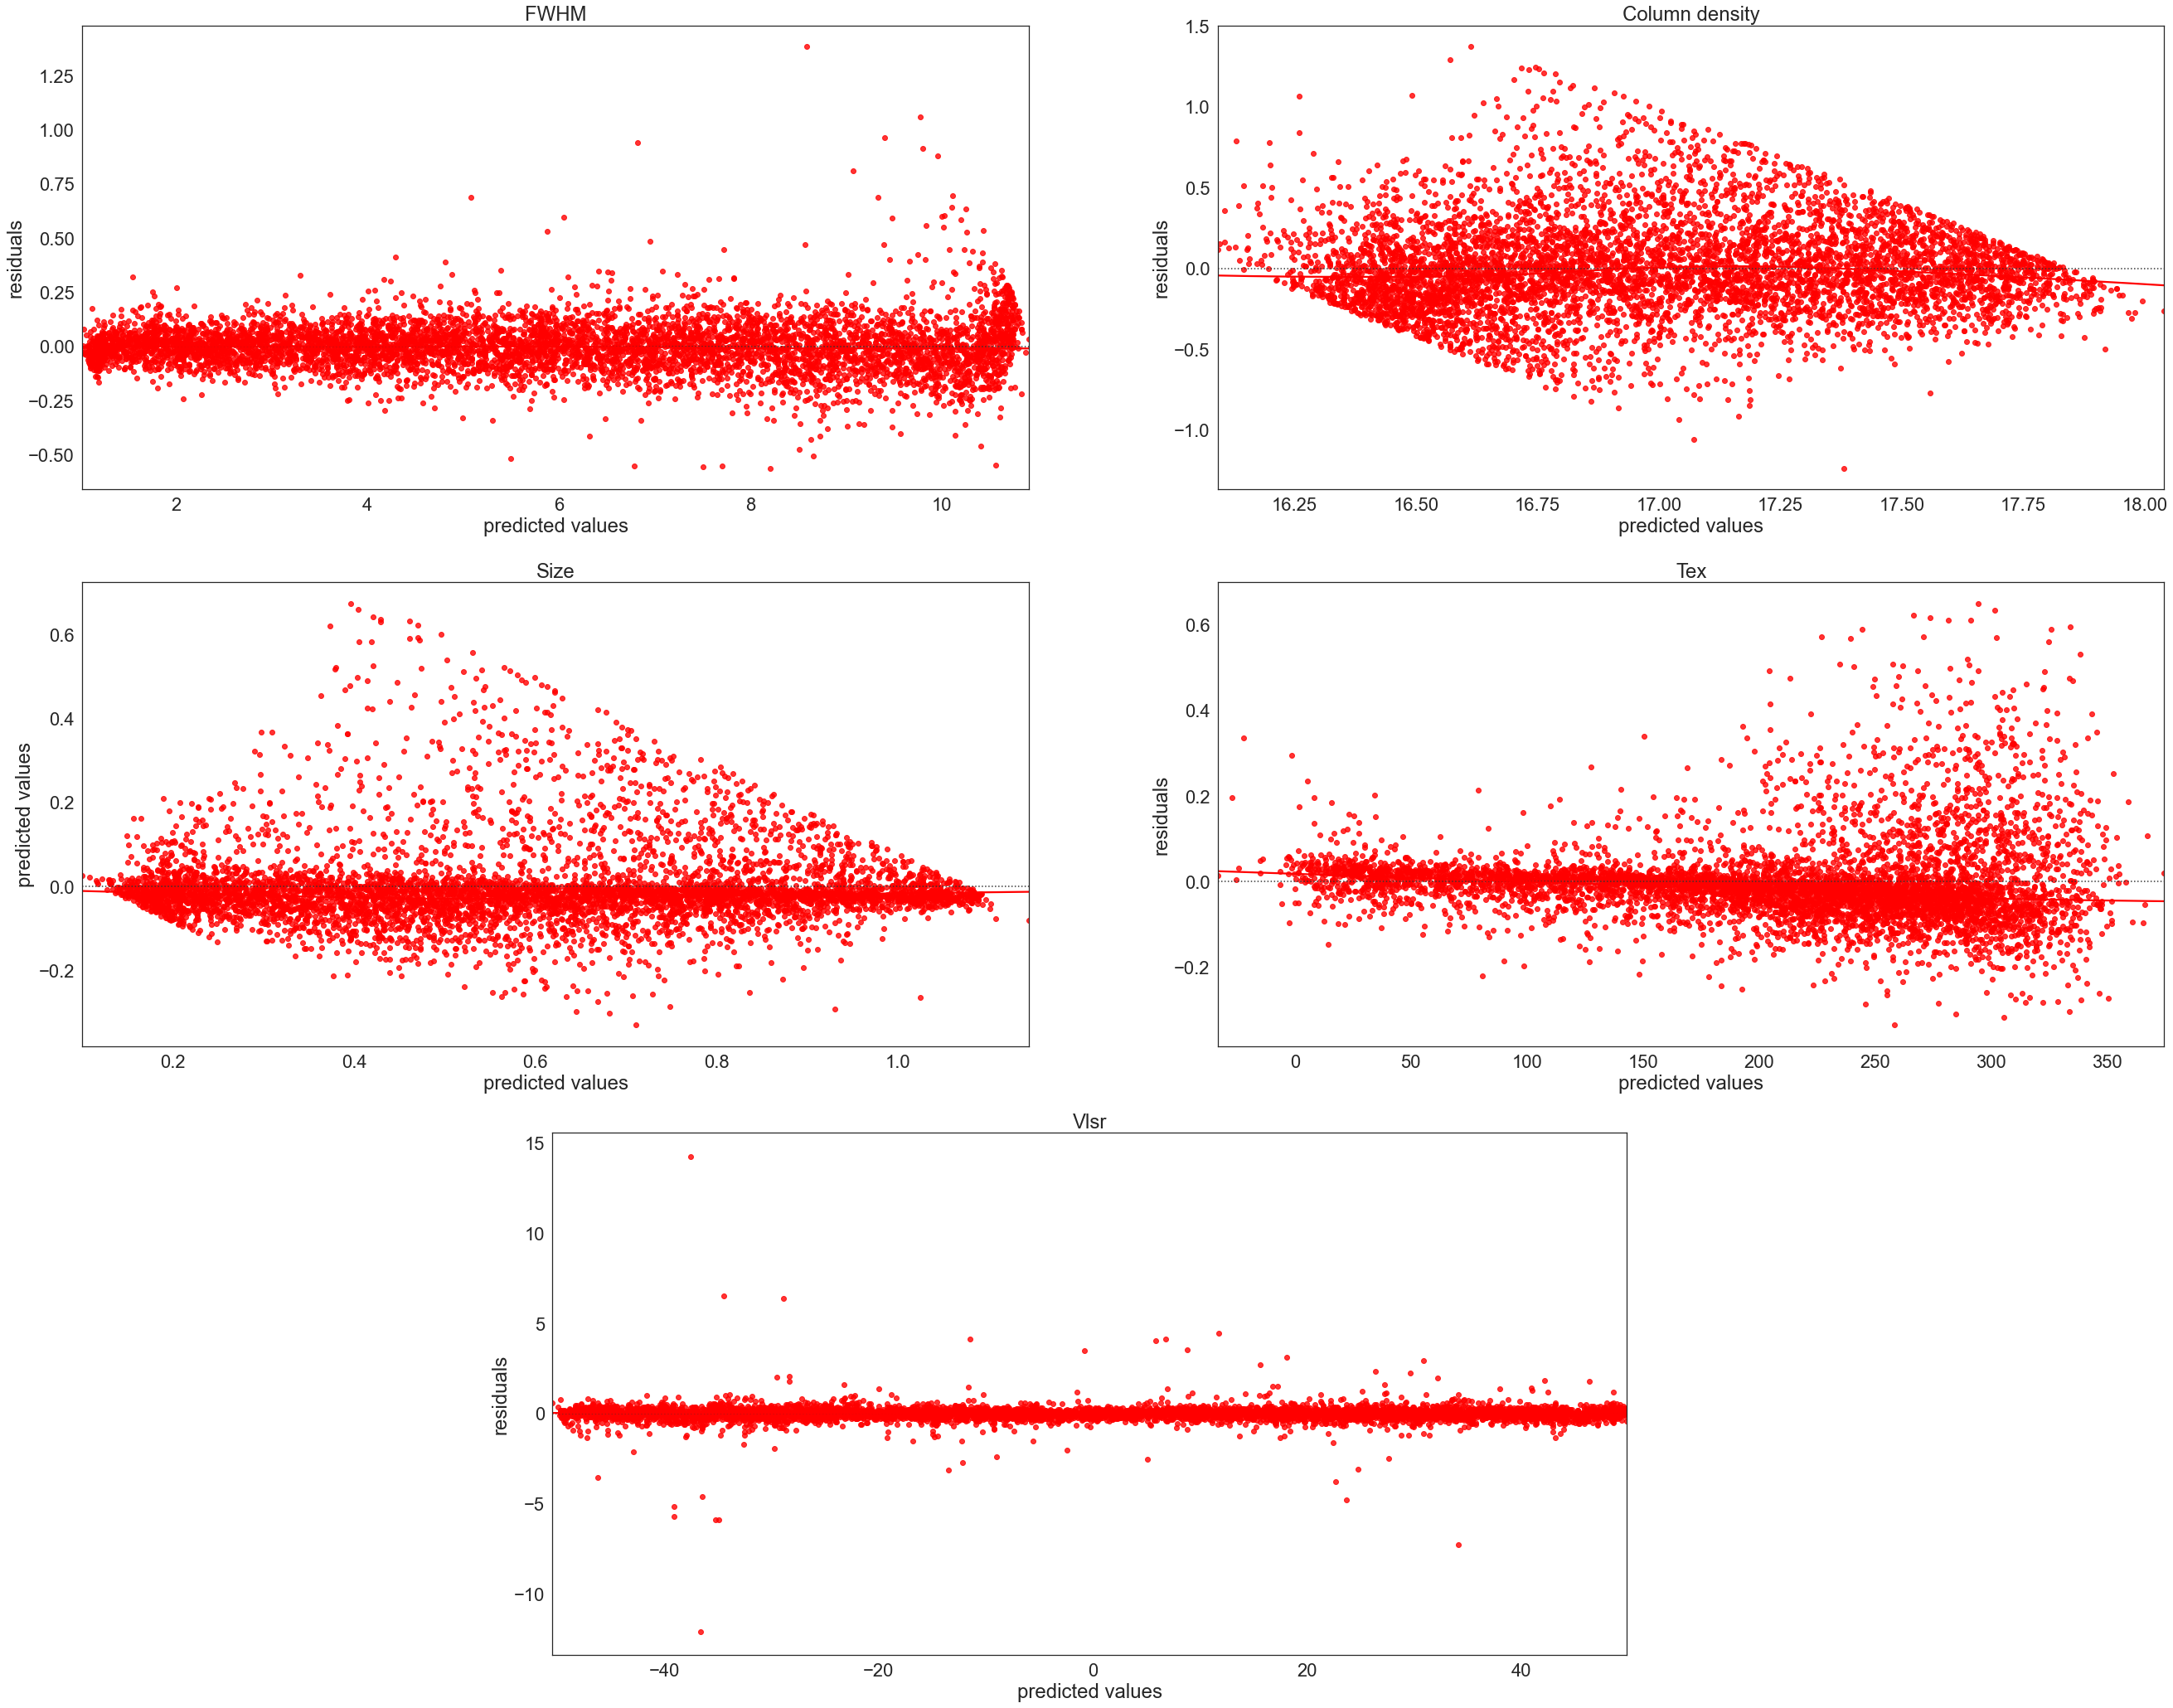

In [172]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig(GENERATED_FILES_OUTPUT + "residuals_XGB_10K.pdf", dpi=15000)
plt.show()

### XGBoost Hyperparameter Tuning

In [173]:
# params = dict(
#     estimator__n_estimators = [100, 200, 500, 750, 1000],
#     estimator__learning_rate = [0.01, 0.03, 0.1],
#     estimator__max_depth =  [3, 5, 7, 10],
#     estimator__min_child_weight = [1, 3, 5, 7, 10],
#     estimator__colsample_bytree = [0.5, 0.7],
#     estimator__eta = [x for x in np.linspace(0.1, 0.6, 6)],
#     estimator__gamma = [int(x) for x in np.linspace(0, 0.5, 6)],
#     estimator__objective = ['reg:squarederror', 'reg:squaredlogerror'] 
# )

# xgb_model = MultiOutputRegressor(
#     xgb.XGBRegressor()
# )

# seed_cv = 123
# kf = KFold(n_splits=5, shuffle=True, random_state=seed_cv)
# xgb_gridseach = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=params,
#     cv=kf,
#     n_jobs=-1,
#     verbose=1
# )


In [174]:
# xgb_model.get_params().keys()

In [175]:
# xgb_gridseach.fit(X_train, y_train)

In [176]:
# xgb_gridseach.best_params_

### Best parameters 

{'estimator__colsample_bytree': 0.5,
 'estimator__learning_rate': 0.03,
 'estimator__max_depth': 10,
 'estimator__n_estimators': 500,
 'estimator__objective': 'reg:squarederror'}

#### Best Fit

In [177]:
xgb_tuned_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=12,
        colsample_bytree=0.5,
        subsample=0.8,
        min_child_weight=1.0,
        objective='reg:squarederror'
   
    )
)

In [178]:
xgb_tuned_model.fit(X_train, y_train, verbose=1)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.03,
                                            max_delta_step=None, max_depth=12,
                                            min_child_weight=1.0, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
         

In [179]:
# get training score
y_multixgb_pred = xgb_tuned_model.predict(X_train)
residuals_xgb = (y_train - y_multixgb_pred)
print('training score: ', xgb_tuned_model.score(X_train, y_train), '\n', 'test score: ', xgb_tuned_model.score(X_test, y_test))

training score:  0.998085828418384 
 test score:  0.8946363906670254


In [180]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(xgb_tuned_model, X_train, y_train, cv=kfold)
# print the r2 score for each fold and the mean r2 score
print("Results: %.4f (%.4f) MSE" % (results.mean(), results.std()))


Results: 0.8879 (0.0033) MSE


In [181]:
y_multixgb_tuned_pred = xgb_tuned_model.predict(X_test)

### metrics

In [182]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_tuned_pred))

mae : 7.4054113753449915
mse : 492.934106127658
rmse : 22.202119406211157
mape : fwhm     1.209551
ntot     1.204896
size    11.817512
tex     25.343332
vlsr     1.962369
dtype: float64
r2 : 0.8946363906670254


In [183]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
kf_cv_scores = cross_val_score(xgb_tuned_model, X_train, y_train, cv=kfold)
print("KFold cross validation score:%.2f", kf_cv_scores.mean())

KFold cross validation score:%.2f 0.887896385613567


In [184]:
xgb_tuned_model.fit(X_train, y_train)
y_multixgb_tuned_pred_cv = xgb_tuned_model.predict(X_test)
# metrics
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_tuned_pred_cv).round(5))

mae : 7.40541
mse : 492.93411
rmse : 22.20212
mape : fwhm     1.20955
ntot     1.20490
size    11.81751
tex     25.34333
vlsr     1.96237
dtype: float64
r2 : 0.89464


### save the predicted parameters for the tuned model to a csv file

In [185]:
param_df_xgb_tuned = pd.DataFrame(y_multixgb_tuned_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
param_df_xgb_tuned['ntot'] = np.array(10**param_df_xgb_tuned['ntot'])
param_df_xgb_tuned.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_xgb_tuned.csv')

In [186]:
param_df_xgb_tuned.head()

fwhm          ntot      size         tex       vlsr
10650   5.386211  3.704270e+17  0.414272  281.426392 -21.903633
2041   10.398227  3.156561e+16  0.423221  152.520493 -13.452147
8668    6.312857  2.844502e+17  1.035447  211.652969  32.527557
1114    1.527039  1.008623e+17  0.323917  224.886993 -38.108467
13902   6.785460  2.663842e+16  0.561016   37.230770  14.291655

#### save the model 

In [187]:
# save the model using joblib
joblib.dump(xgb_tuned_model, MODELS_OUTPUT + 'xgb_tuned_model.pkl')

['../data/models/xgb_tuned_model.pkl']

### Halving Random Search

In [188]:
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV


# model = MultiOutputRegressor(
#     xgb.XGBRegressor(
#         n_estimators=500,
#         learning_rate=0.03,
#         max_depth=12,
#         colsample_bytree=0.5,
#         subsample=0.8,
#         min_child_weight=1.0,
#         objective='reg:squarederror'
#     )
# )

# param_grid = {
#     'estimator__n_estimators': [100, 200, 500, 750, 1000],
#     'estimator__learning_rate': [0.01, 0.03, 0.1],
#     'estimator__max_depth':  [3, 5, 7, 10],
#     'estimator__min_child_weight': [1, 3, 5, 7, 10],
#     'estimator__colsample_bytree': [0.5, 0.7],
#     'estimator__eta': [x for x in np.linspace(0.1, 0.6, 6)],
#     'estimator__gamma': [int(x) for x in np.linspace(0, 0.5, 6)],
#     'estimator__objective': ['reg:squarederror', 'reg:squaredlogerror']
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# hs = HalvingGridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=metrics.r2_score,
#     cv=kf,
#     n_jobs=-1,
#     verbose=2
# )

In [189]:
# hs.fit(X_train, y_train)

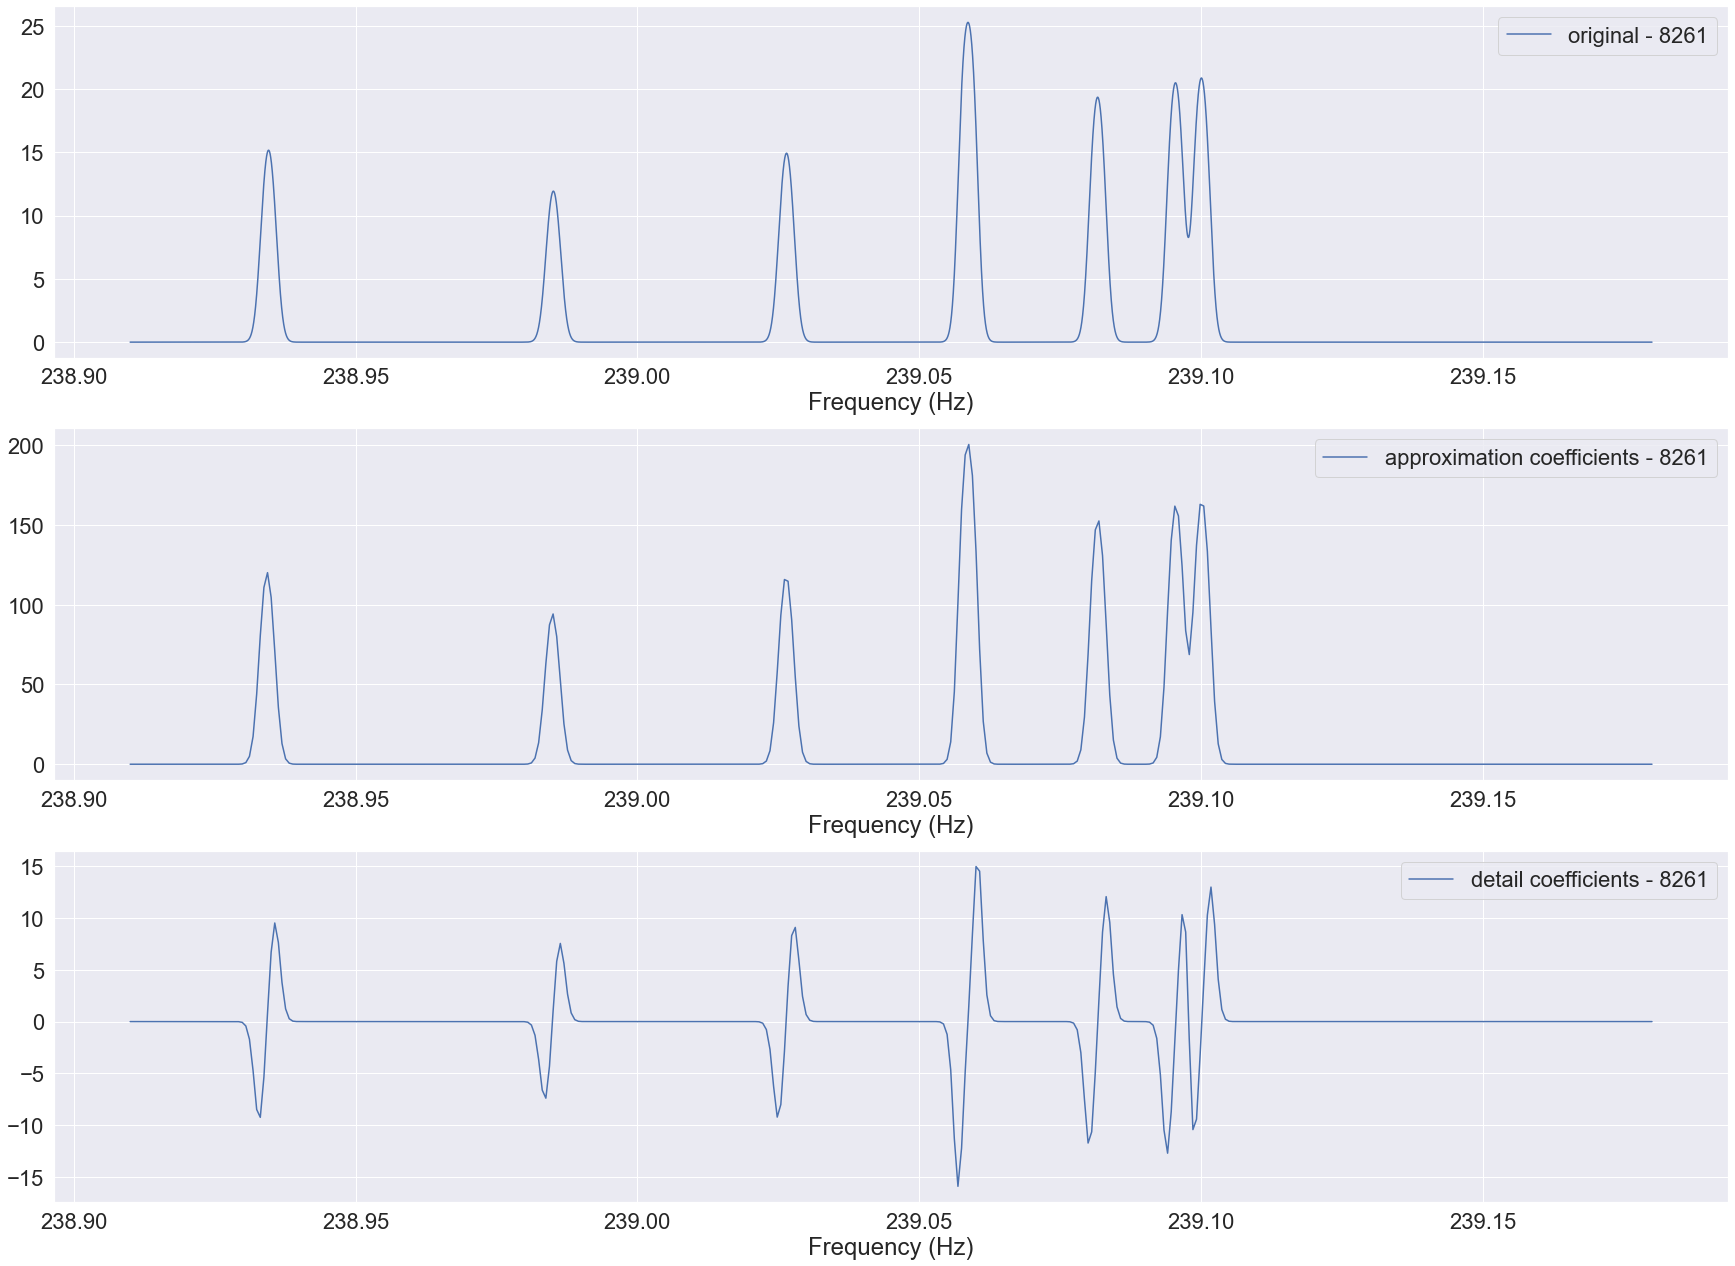

In [190]:
plt.figure(figsize=(30,22))
plt.subplot(3,1,1)
plt.plot(freq_sig[932]  ,signal[932], label='original - 8261')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(x_new_freq, approx_coeffs[932], label='approximation coefficients - 8261')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(x_new_freq, detail_coeffs[932], label='detail coefficients - 8261')
plt.xlabel('Frequency (Hz)')
plt.legend()

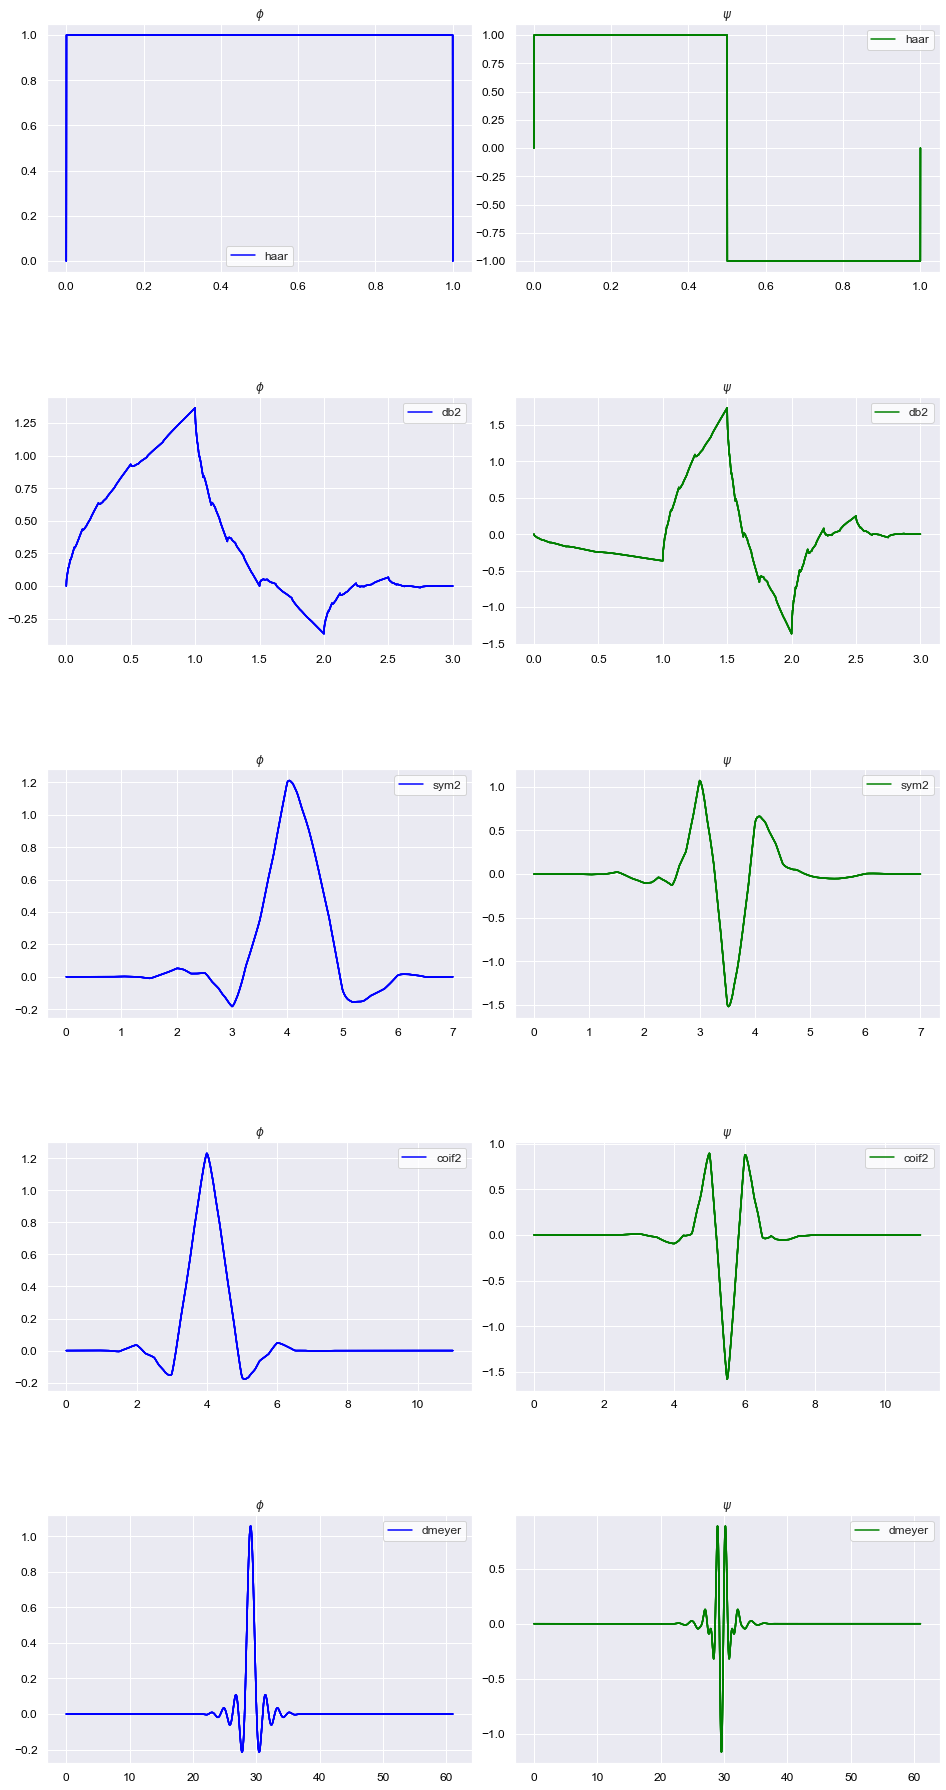

In [191]:
# Daubechies "least asymmetric" wavelets with 12 vanishing points
haar = pywt.Wavelet('haar')
db2 = pywt.Wavelet("db2")
sym2 = pywt.Wavelet("sym4")
coif2 = pywt.Wavelet("coif2")
# bior2 = pywt.Wavelet("bior2.2")
# rbio2 = pywt.Wavelet("rbio2.2")
dmeyer = pywt.Wavelet("dmey")


phi_h, psi_h, x_h = haar.wavefun(level=12)
phi_db2, psi_db2, x_db2 = db2.wavefun(12)
phi_s2, psi_s2, x_s2 = sym2.wavefun(12)
phi_c2, psi_c2, x_c2 = coif2.wavefun(12)
# phi_b, psi_b, x_b = bior2.wavefun(12)
# phi_r2, psi_r2, x_r2 = rbio2.wavefun(12)
phi_d, psi_d, x_d = dmeyer.wavefun(5)



fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,32), gridspec_kw={'hspace': 0.5, 'wspace': 0.1})

sns.set_style('whitegrid', {'axes.grid' : False})
# plt.suptitle("Main Title", size=16)


# loop over the rows and columns of the figure
for i in range(5):
    axes[0, 0].plot(x_h, phi_h, 'blue', label='haar')
    axes[0, 0].legend(['haar'], fontsize=12)
    axes[0, 1].plot(x_h, psi_h, 'green', label='haar')
    axes[0, 1].legend(['haar'], fontsize=12)

    axes[1, 0].plot(x_db2, phi_db2, 'blue', label='db2')
    axes[1, 0].legend(['db2'], fontsize=12)
    axes[1, 1].plot(x_db2, psi_db2, 'green', label='db2')
    axes[1, 1].legend(['db2'], fontsize=12)    

    axes[2, 0].plot(x_s2, phi_s2, 'blue', label='sym2')
    axes[2, 0].legend(['sym2'], fontsize=12)
    axes[2, 1].plot(x_s2, psi_s2, 'green', label='sym2')
    axes[2, 1].legend(['sym2'], fontsize=12)

    axes[3, 0].plot(x_c2, phi_c2, 'blue', label='coif2')
    axes[3, 0].legend(['coif2'], fontsize=12)
    axes[3, 1].plot(x_c2, psi_c2, 'green', label='coif2')
    axes[3, 1].legend(['coif2'], fontsize=12)

    axes[4, 0].plot(x_d, phi_d, 'blue', label='dmeyer')
    axes[4, 0].legend(['dmeyer'], fontsize=12)
    axes[4, 1].plot(x_d, psi_d, 'green', label='dmeyer')
    axes[4, 1].legend(['dmeyer'], fontsize=12)

    # set x and y ticks sizes
    axes[i, 0].tick_params(axis='x', labelsize=12, colors='black')
    axes[i, 0].tick_params(axis='y', labelsize=12, colors='black')
    axes[i, 1].tick_params(axis='x', labelsize=12, colors='black')
    axes[i, 1].tick_params(axis='y', labelsize=12, colors='black')

    axes[i, 0].set_title('$\phi$', fontsize=12, fontweight='bold')
    axes[i, 1].set_title('$\psi$', fontsize=12, fontweight='bold')


plt.savefig(GENERATED_FILES_OUTPUT + 'wavelets_types.pdf', dpi=15000)



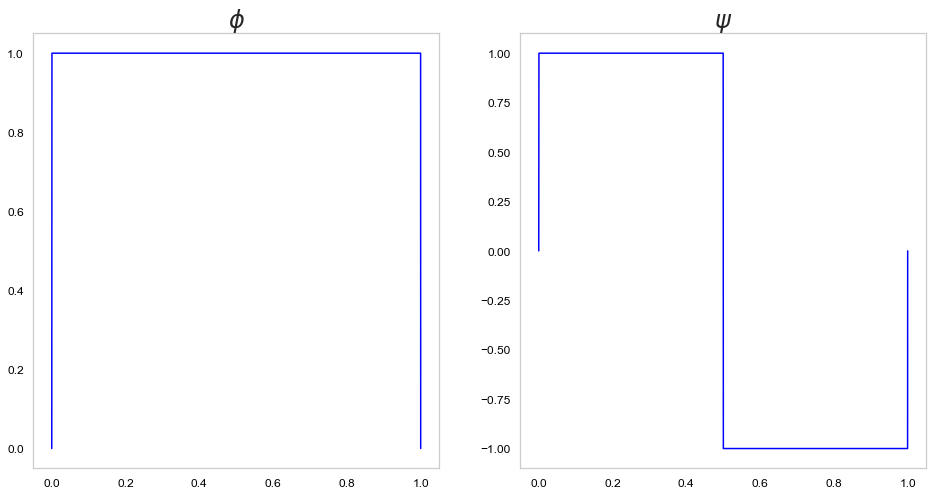

In [192]:
db1 = pywt.Wavelet("db1")
phi_db1, psi_db1, x_db1 = db1.wavefun(12)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title("$\phi$")
plt.plot(x_db1,phi_db1, color='blue')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.title("$\psi$")
plt.plot(x_db1,psi_db1, color='blue')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.savefig(GENERATED_FILES_OUTPUT + 'wavelets_db1.pdf', dpi=15000)



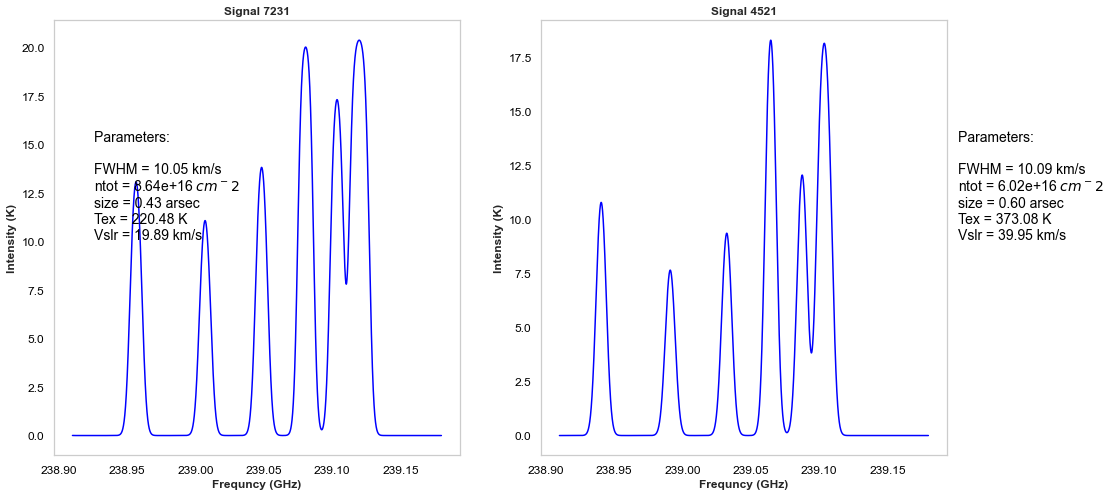

In [193]:
sig7231_params = df_param.iloc[7231, :]
sig4521_params = df_param.iloc[4521, :]


plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(freq_sig[7231],  signal[7231], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.gcf().text(0.16, 0.5, 'Parameters: \n \nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arsec \nTex = {:.2f} K \nVslr = {:.2f} km/s'.format(sig7231_params[0], sig7231_params[1], sig7231_params[2], sig7231_params[3], sig7231_params[4]), fontsize=14, color='black') 
plt.title('Signal 7231', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.plot(freq_sig[4521],  signal[4521], color='blue', label='original - 4521')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.gcf().text(0.91, 0.5, 'Parameters: \n \nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arsec \nTex = {:.2f} K \nVslr = {:.2f} km/s'.format(sig4521_params[0], sig4521_params[1], sig4521_params[2], sig4521_params[3], sig4521_params[4]), fontsize=14, color='black')
plt.title('Signal 4521', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')

plt.show

plt.savefig(GENERATED_FILES_OUTPUT + 'signal_params.pdf', dpi=15000)


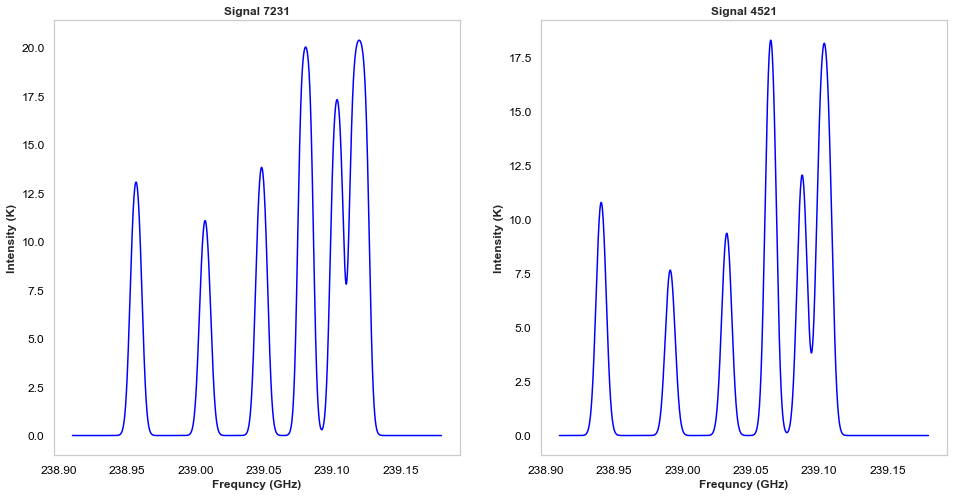

In [194]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(freq_sig[7231],  signal[7231], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.title('Signal 7231', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.plot(freq_sig[4521],  signal[4521], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.title('Signal 4521', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.show

plt.savefig(GENERATED_FILES_OUTPUT + 'optically_thick_thin.pdf', dpi=15000)